# Set up

### Libraries

In [3]:
import inflection
import math
import datetime
import random
import pickle 
import requests
import json


import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from scipy                  import stats  as ss
from boruta                 import BorutaPy


from tabulate               import tabulate
from IPython.display        import Image
from matplotlib             import pyplot as plt
from IPython.display        import HTML
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso


### Functions

In [4]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()

    n = cm.sum() 
    r, k = cm.shape 

    chi2 = ss.chi2_contingency( cm )[0] 
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):

    mae = mean_absolute_error( y, yhat ) 
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [5]:
jupyter_settings()

### Import data

In [6]:
df_sales_raw = pd.read_csv('dataset/train_rossmann.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store_rossmann.csv', low_memory=False)

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')

## ETL

#### Data raw status 

In [7]:
# Saving
df1 = df_raw.copy()

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
df1.dtypes

# Need changes: 

# Date                          object
# DayOfWeek                      int64
# SchoolHoliday                  int64
# CompetitionOpenSinceMonth    float64
# CompetitionOpenSinceYear     float64
# Promo2SinceWeek              float64
# Promo2SinceYear              float64

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [10]:
df1.isna().sum()

# Need change:

# CompetitionDistance            2642
# CompetitionOpenSinceMonth    323348
# CompetitionOpenSinceYear     323348
# Promo2SinceWeek              508031
# Promo2SinceYear              508031
# PromoInterval                508031

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

### Rename Columns

In [11]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list (map ( snakecase, cols_old))

# Rename
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### Fillout NA

In [12]:
# Changing date type

df1['date'] = pd.to_datetime( df1['date'])

In [13]:
# competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan (x) else x )

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval                  508031
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split('.') else 0 , axis=1  )

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### Change Data Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# Descriptive Statistical

### Data Dimensions

In [15]:
# Data Dimensions

print(f'Number of Rows {df1.shape[0]}')
print(f'Number of Columns {df1.shape[1]}')


Number of Rows 1017209
Number of Columns 20


### Basics Statistics

In [16]:
# Split into categorical and numerical attibutes

num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( include=['object'])


In [17]:
# Cental Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( np.min )).T
d3 = pd.DataFrame(num_attributes.apply( np.max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T


# Concatenate
table_m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
table_m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

table_m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


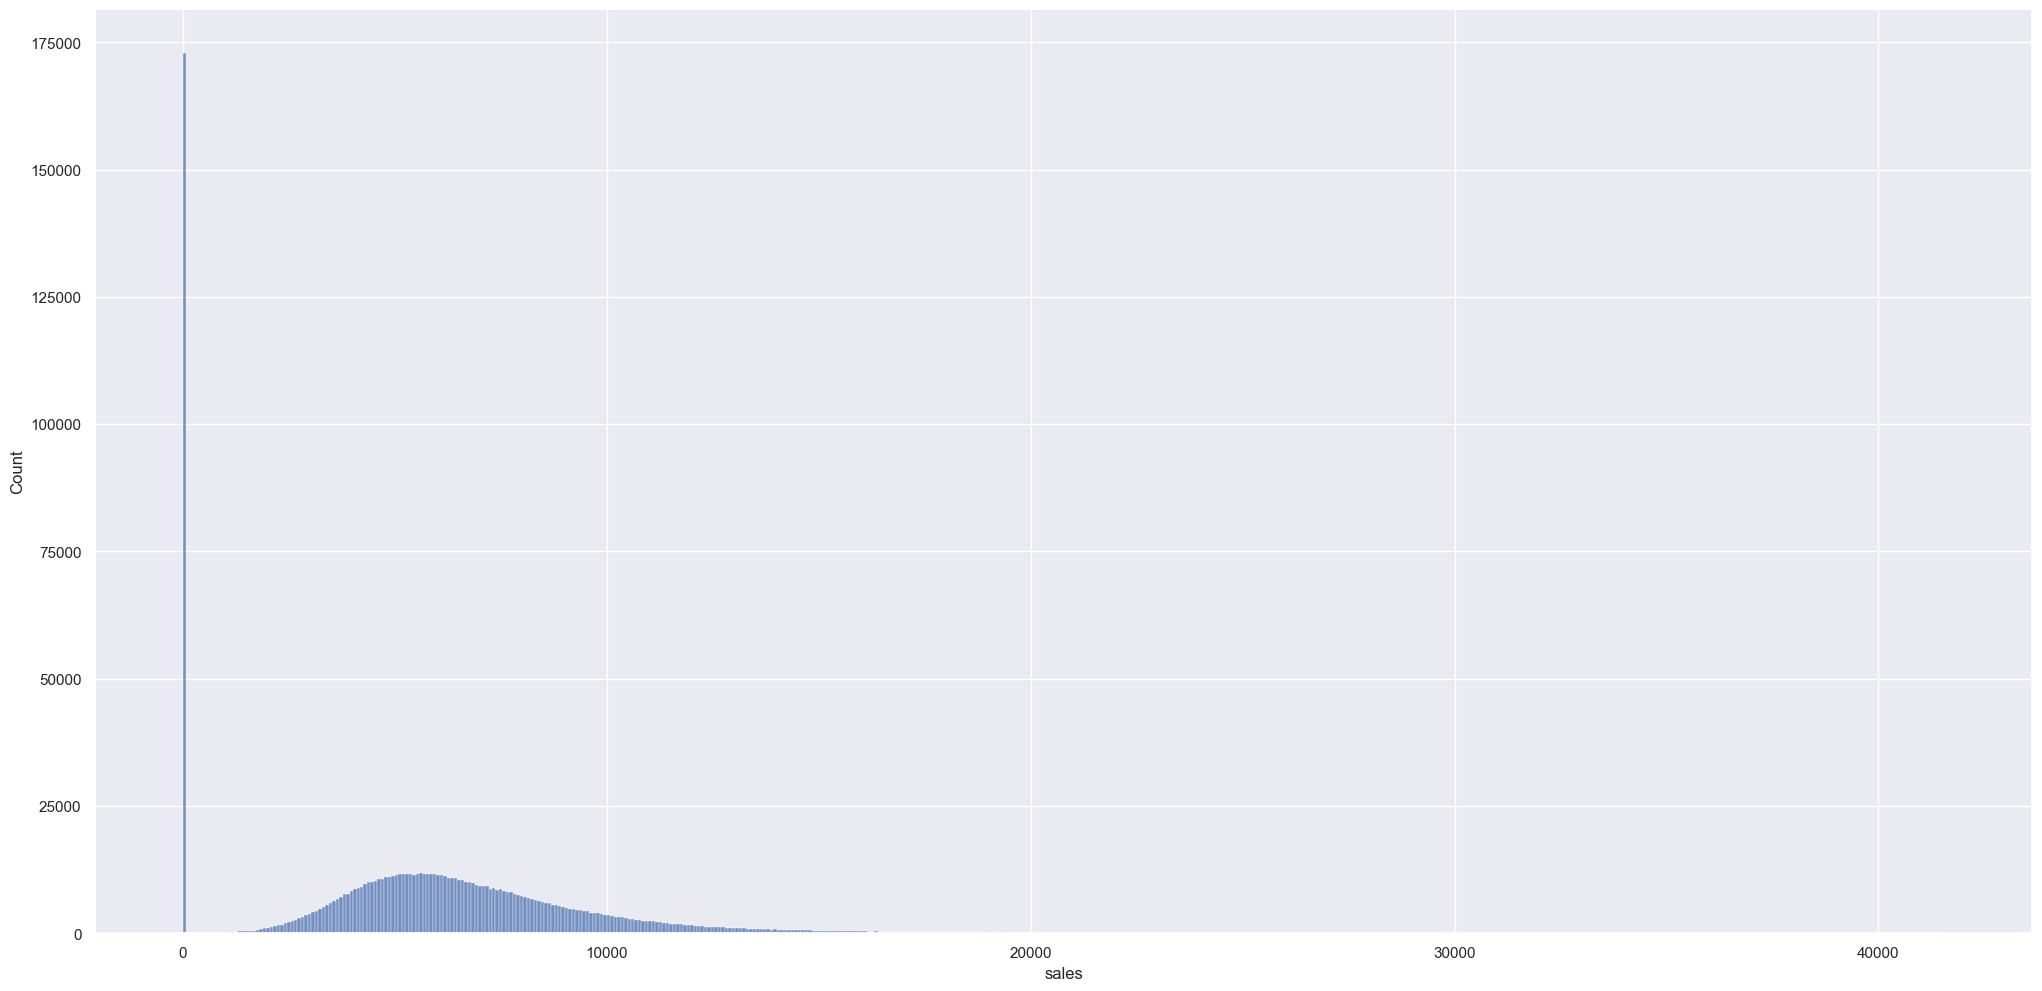

In [18]:
sns.histplot(df1['sales']);

In [19]:
# See the categorical atributes

cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

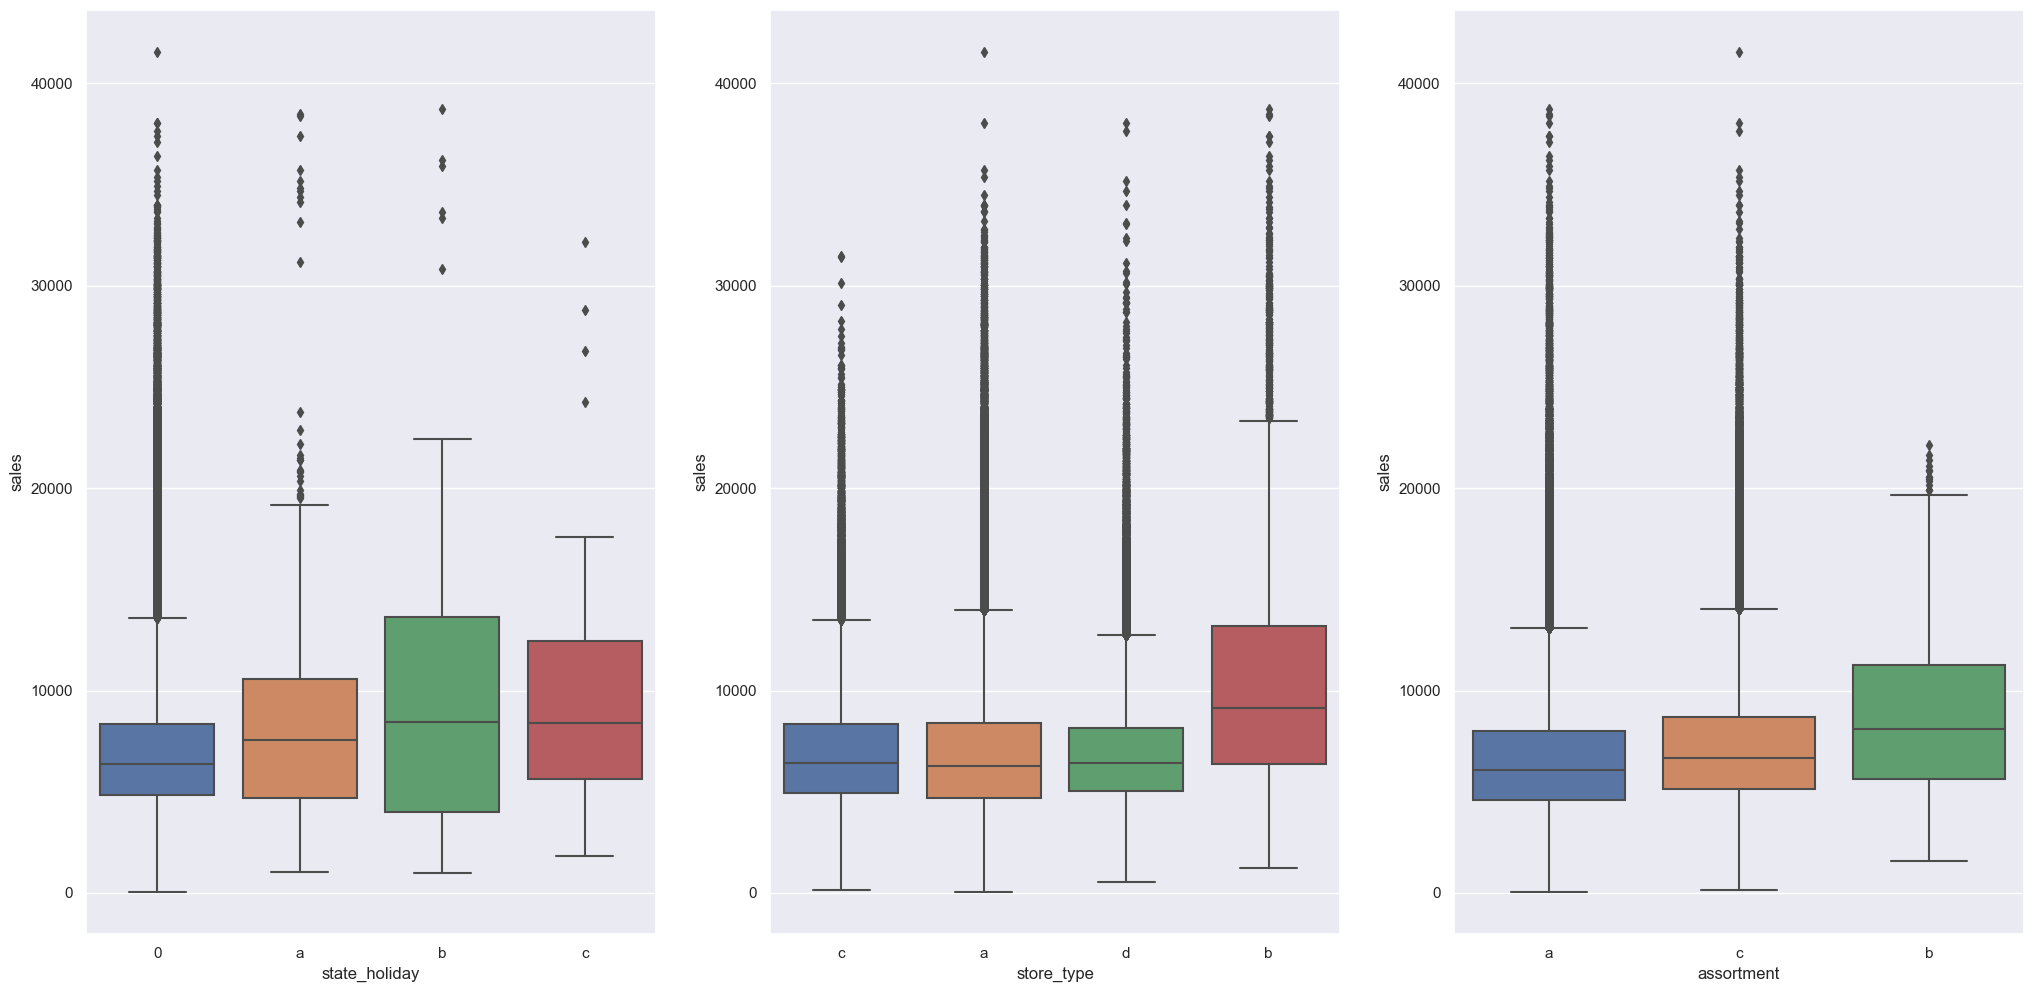

In [20]:
aux1 = df1[( df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# Feature Engineering

### Mental Map

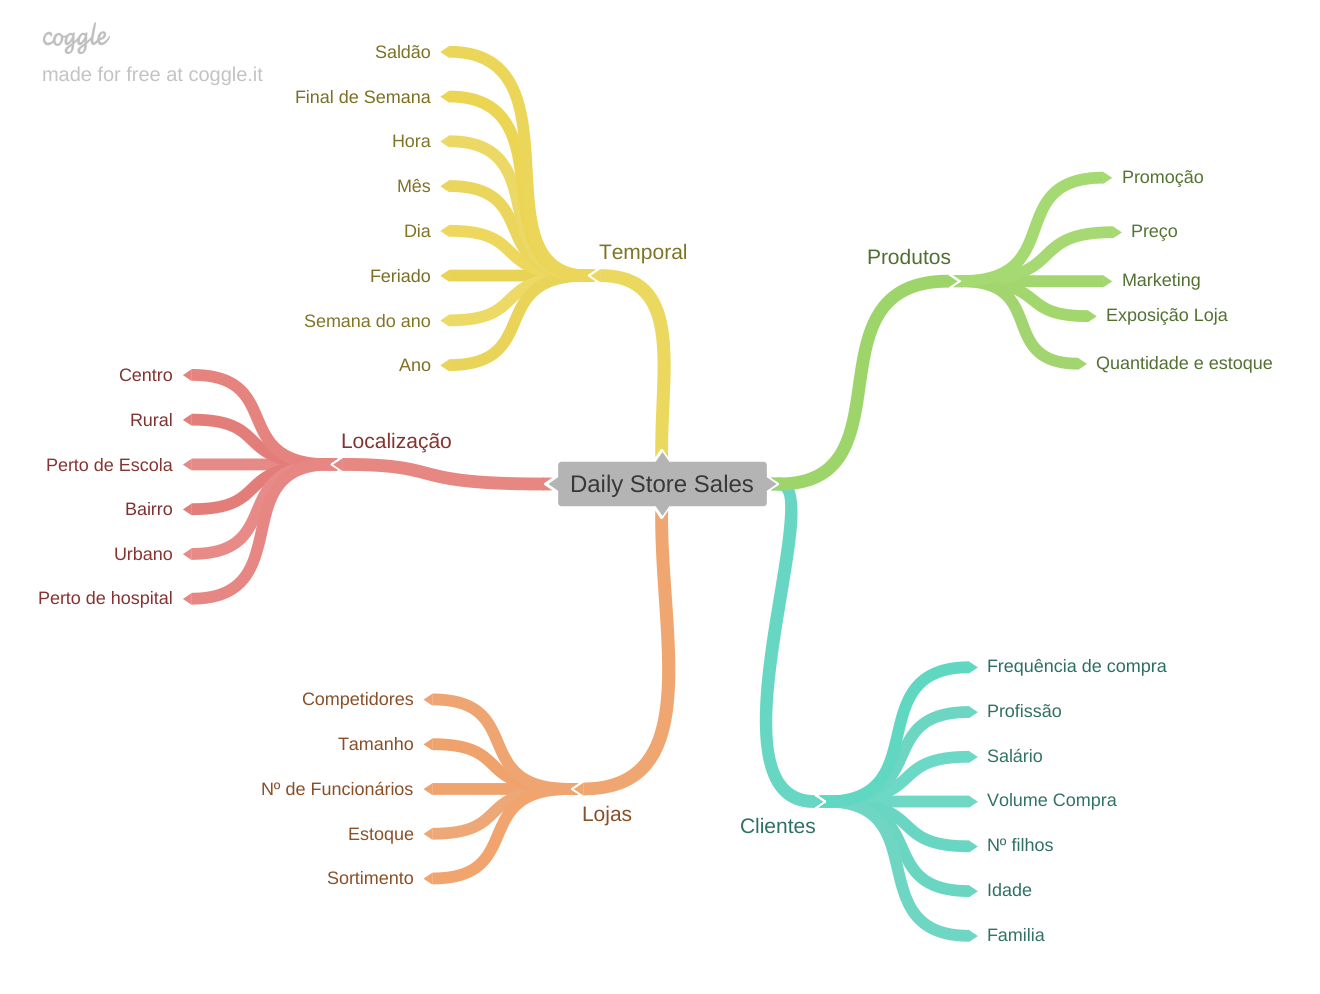

In [21]:
df2= df1.copy()
Image('img/mindmap.png')

### Hyphoteses List



1. Lojas com maior sortimento deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores há mais tempo deveriam vender mais
4. Lojas com promoções mais agressivas (maior desconto) deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais
6. Lojas com mais promoções consecutivas deveriam vender mais
7. Lojas abertas durante feriado final do ano deveriam vender mais
8. Lojas deveriam vender mais ao longo dos anos
9. Lojas deveriam vender mais no segundo semestre do ano
10. Lojas deveriam vender mais depois do dia 10 de cada mês
11. Lojas deveriam vender menos no fds
12. Lojas deveriam vender menos durante os feriados escolares

### Features

In [22]:
# Split Features

# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competition Since 
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] =  ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )


# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype( int )

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [23]:
df3 = df2.copy()

# Filtragem
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

# Seleção
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )



## Exploratory Data Analysis 

In [24]:
# Saving
df4 = df3.copy()

### Univariate Analysis

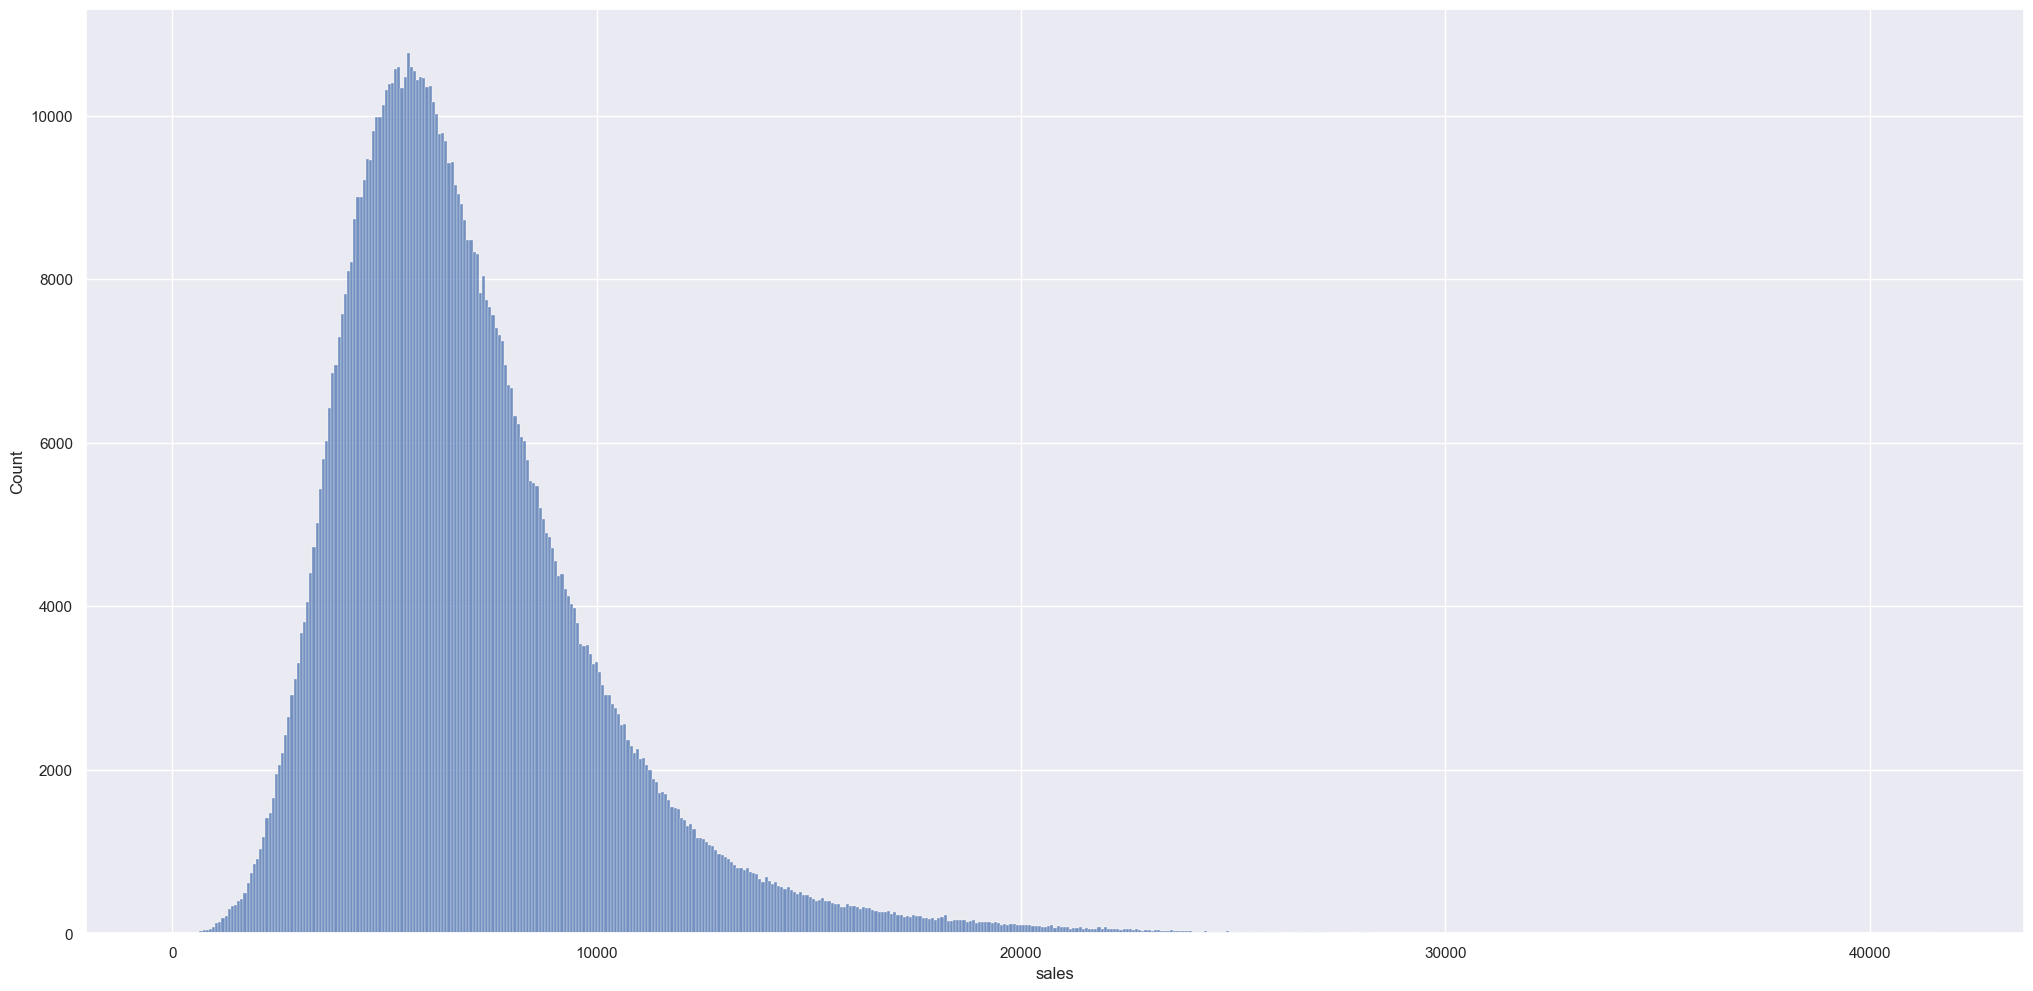

In [25]:
# Response Variabel

sns.histplot( df4['sales'], kde=False);

#### Numerical Variable

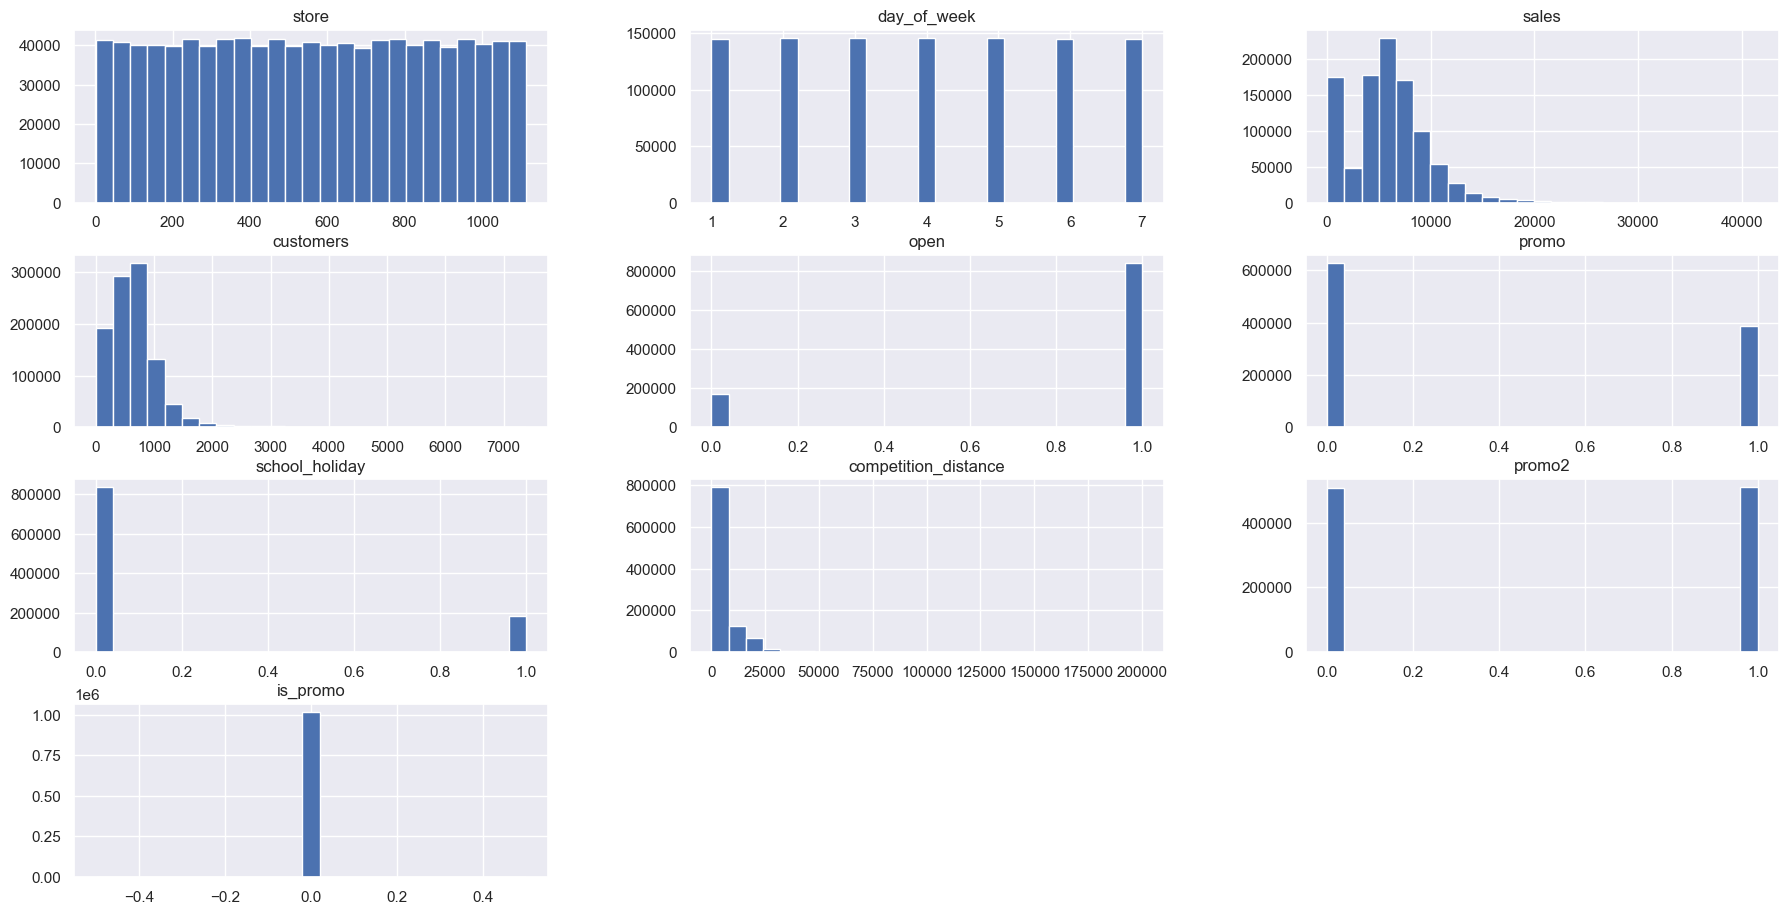

In [26]:


num_attributes.hist( bins=25, figsize=(22, 11) );

#### Categorical Variable

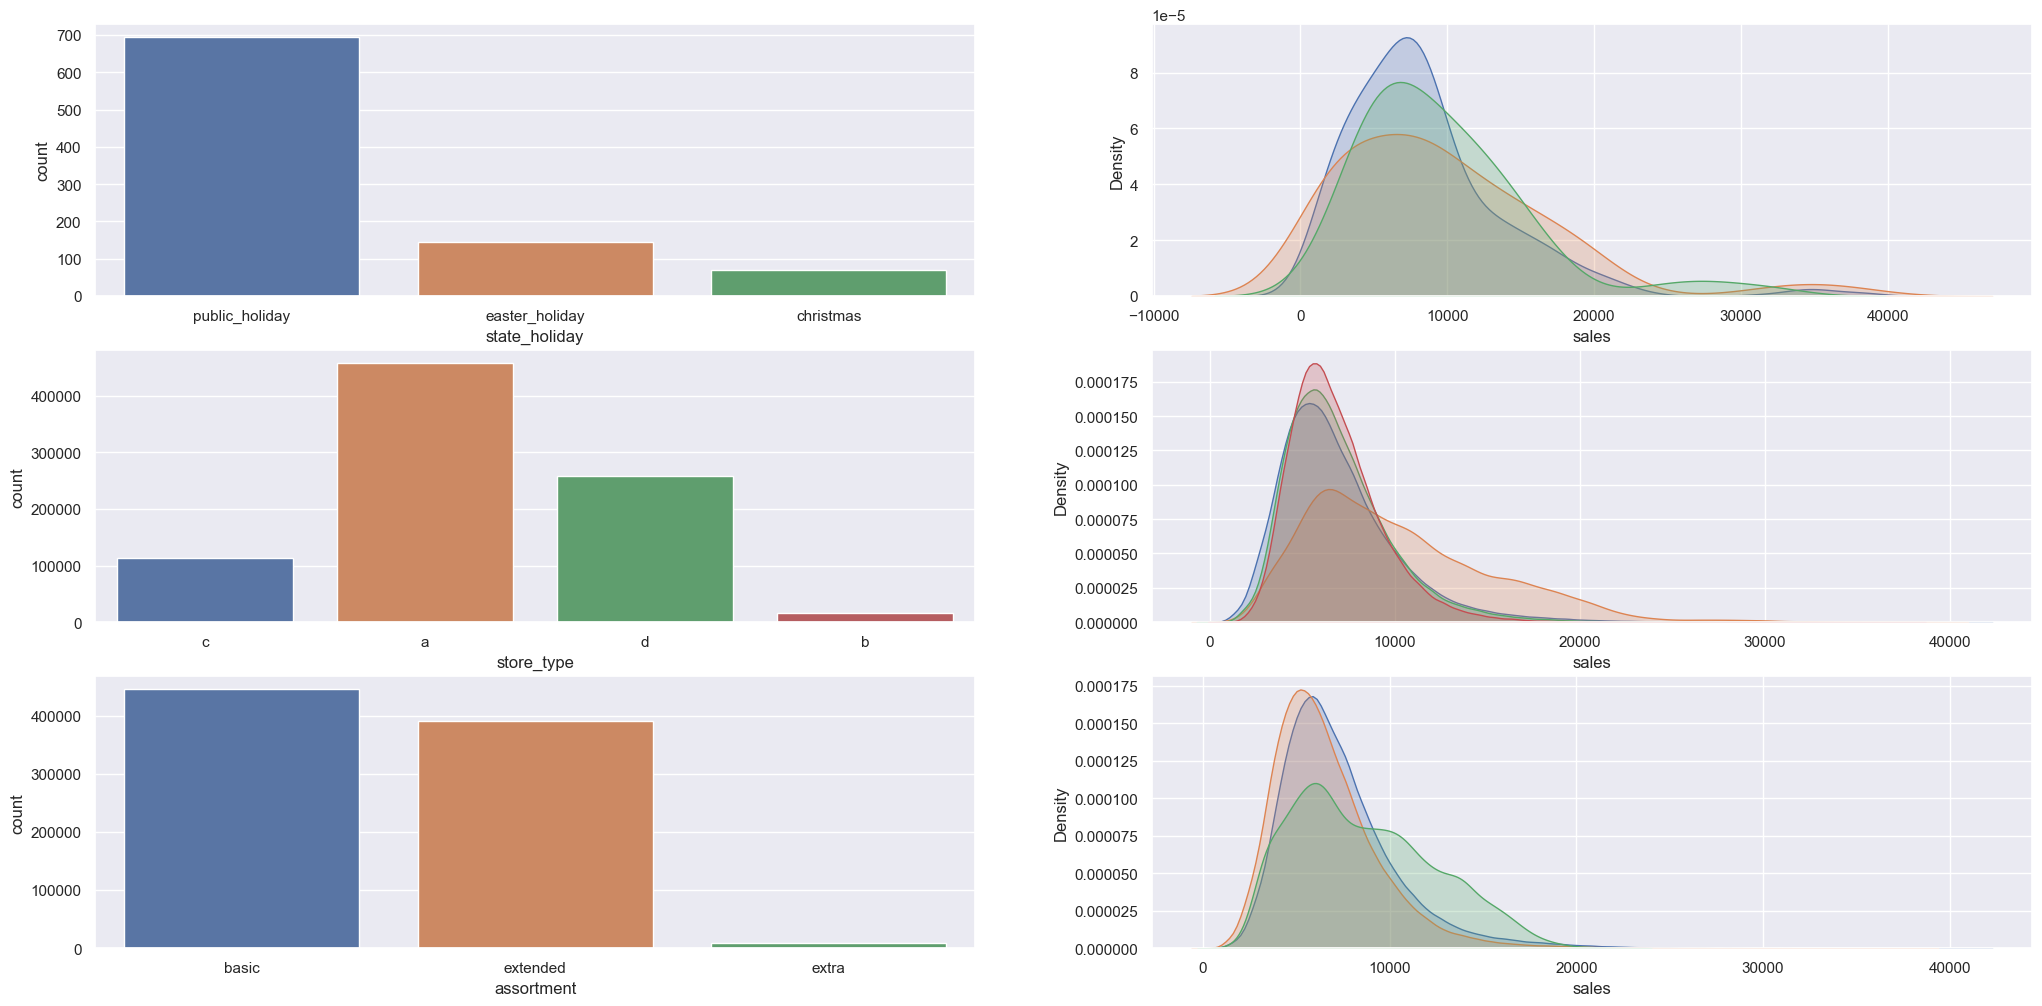

In [27]:
# State Holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] );

# Waves
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True );


#Store type
plt.subplot( 3, 2, 3 )
sns.countplot( x=df4['store_type'] );

#Waves
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True);
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True);
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True);
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True);


# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x=df4['assortment'] );

# Wave
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True);
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True);
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True);

### Bivariate Analysis

In [28]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', 'Falsa', 'Baixa'],
      ['H6', 'Falsa', 'Media'],
      ['H7', 'Falsa', 'Alta'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeira', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           Falsa        Baixa
H6           Falsa        Media
H7           Falsa        Alta
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Baixa


#### More Relevant

##### **H1.** Lojas com maior sortimentos deveriam vender mais.

 **FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

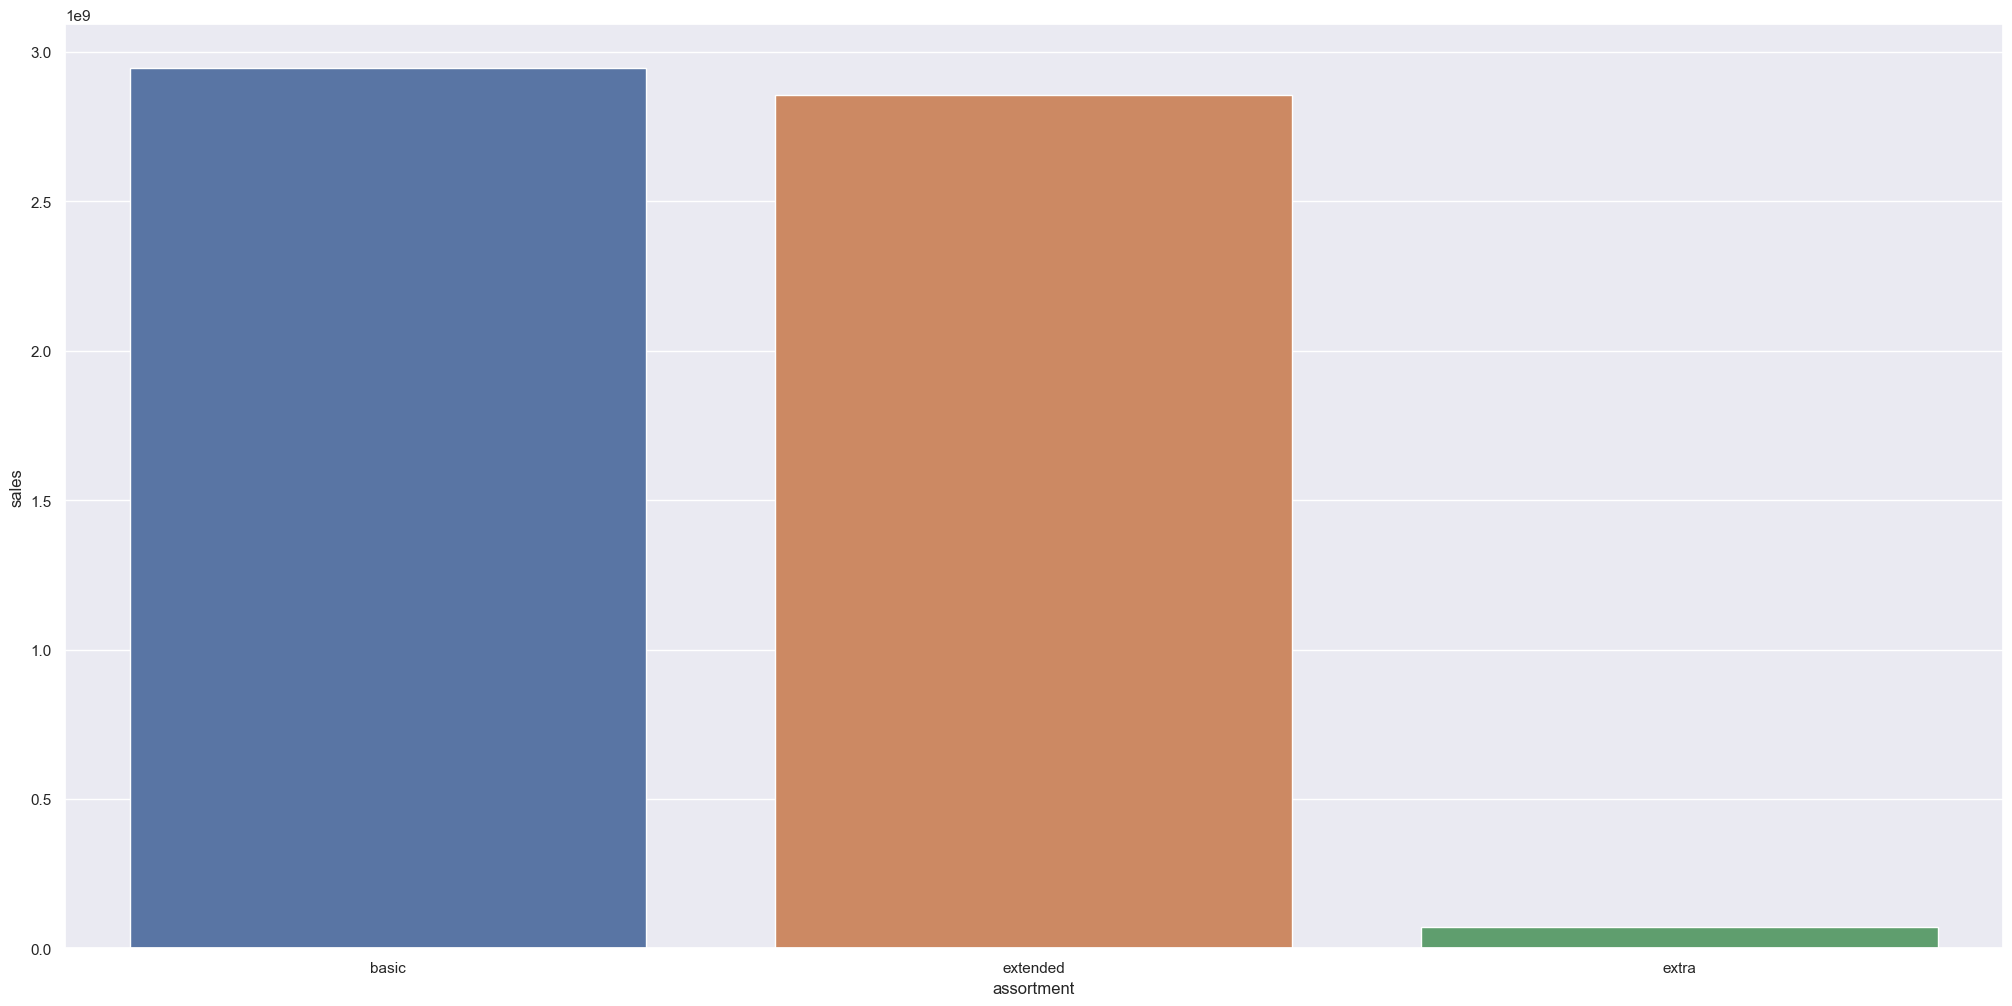

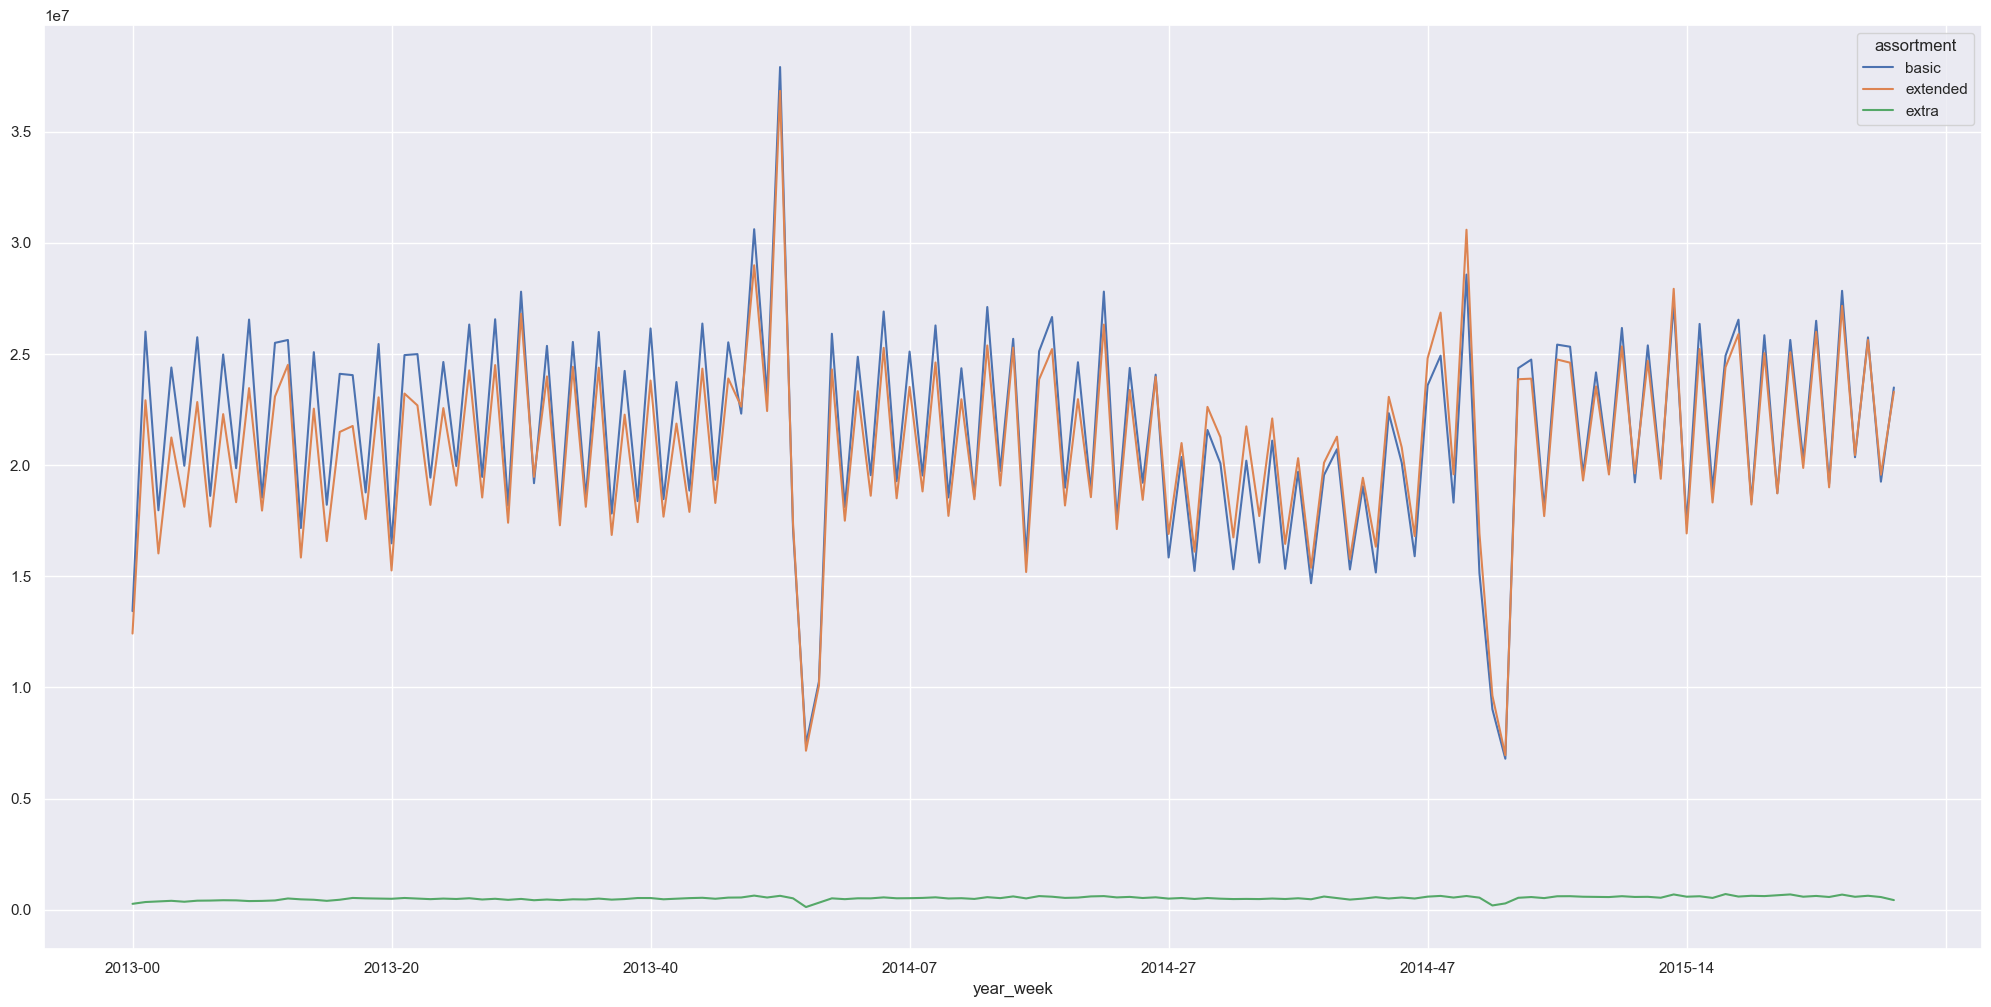

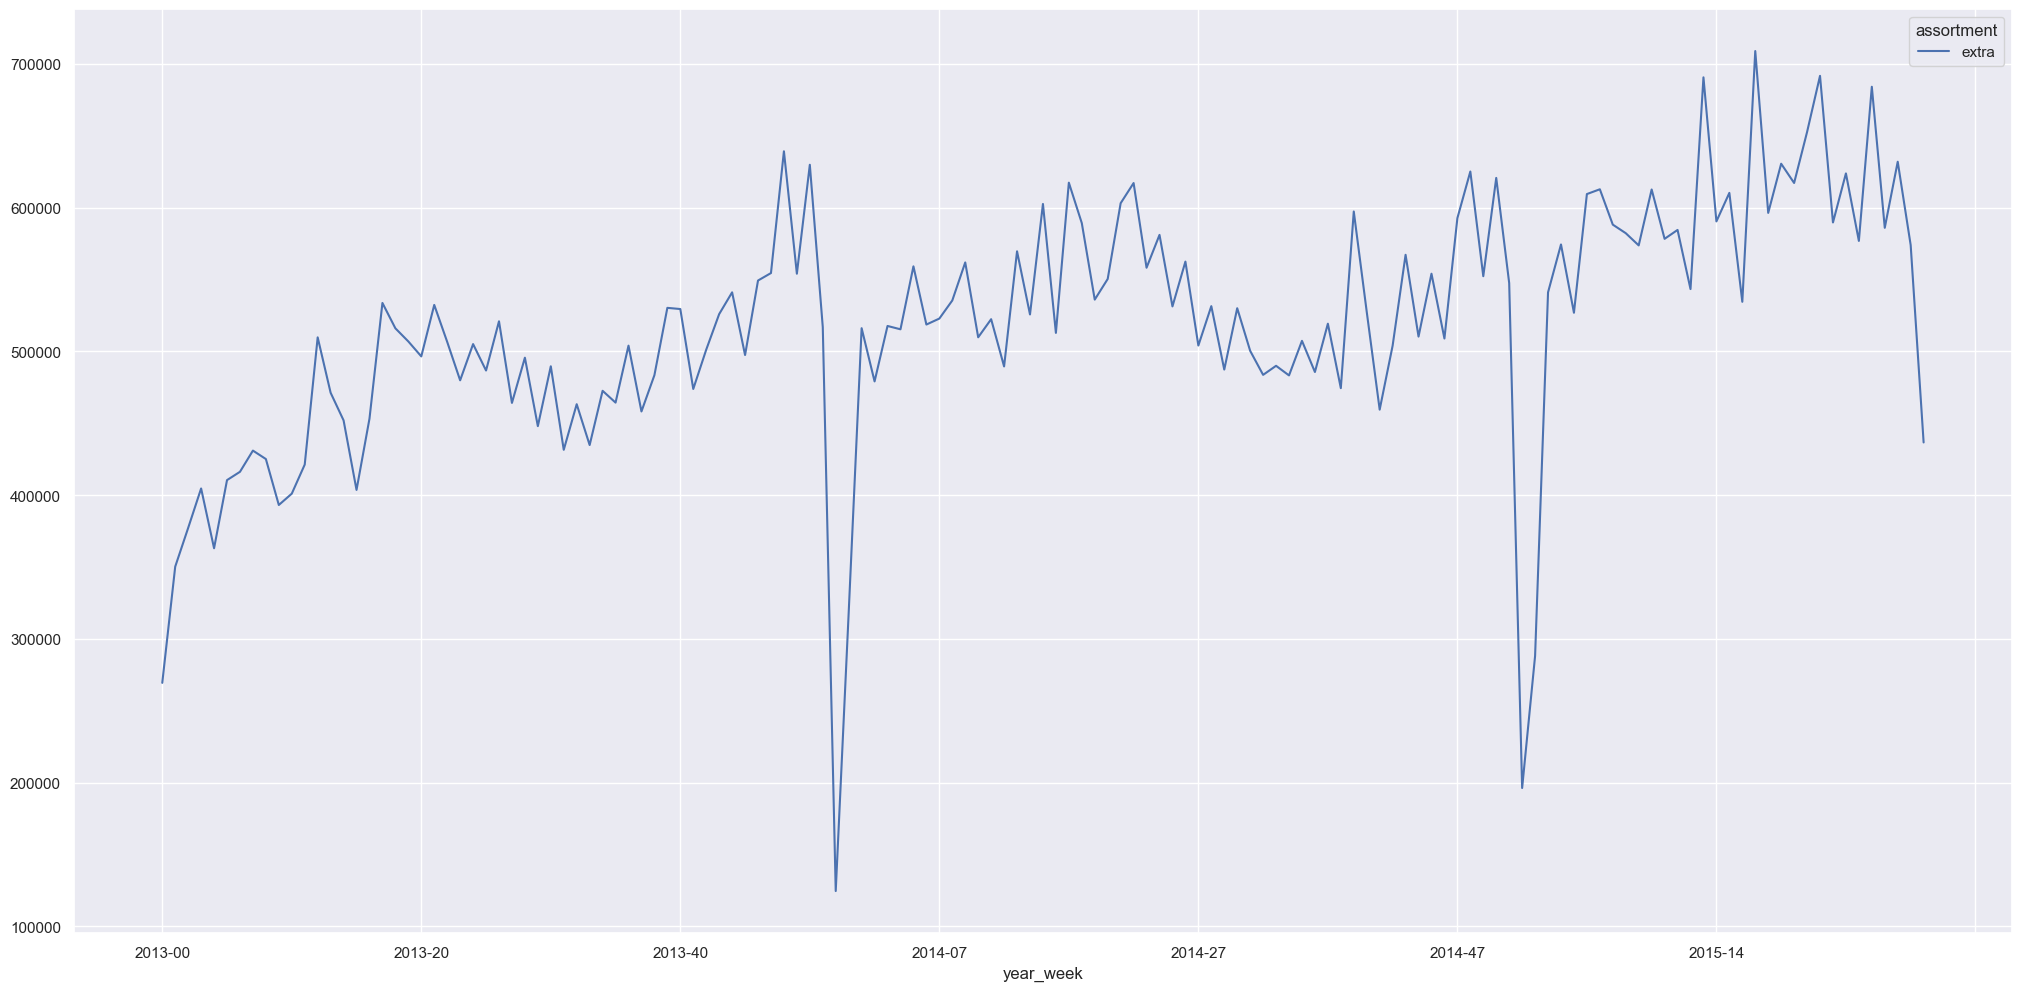

In [29]:
# Total
grf1 = df4[[ 'assortment', 'sales' ]].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=grf1);

# by day
aux2 = df4[[ 'assortment', 'sales', 'year_week' ]].groupby(['year_week', 'assortment']).sum().reset_index()
grf2 = aux2.pivot( index='year_week', columns='assortment', values='sales').plot(); 

# assortment extra
aux3= aux2[aux2['assortment'] == 'extra' ]
grf3 = aux3.pivot( index='year_week', columns='assortment', values='sales').plot(); 



In [30]:
# # Total
# fig, (grf1, grf2, grf3 ) = plt.subplots(3, 1)
# fig.suptitle('Assortment View')

# grf1 = df4[[ 'assortment', 'sales' ]].groupby('assortment').sum().reset_index()
# sns.barplot( x='assortment', y='sales', data=grf1);

# # by day
# grf2 = df4[[ 'assortment', 'sales', 'year_week' ]].groupby(['year_week', 'assortment']).sum().reset_index()
# grf2.pivot( index='year_week', columns='assortment', values='sales').plot(); 


# # assortment extra
# grf3 = aux2[aux2['assortment'] == 'extra' ]
# grf3.pivot( index='year_week', columns='assortment', values='sales').plot(); 

# plt.show()


##### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

C:\Users\Stella-PC\AppData\Local\Temp\ipykernel_12724\282085845.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap( h2.corr( method='pearson' ), annot=True );


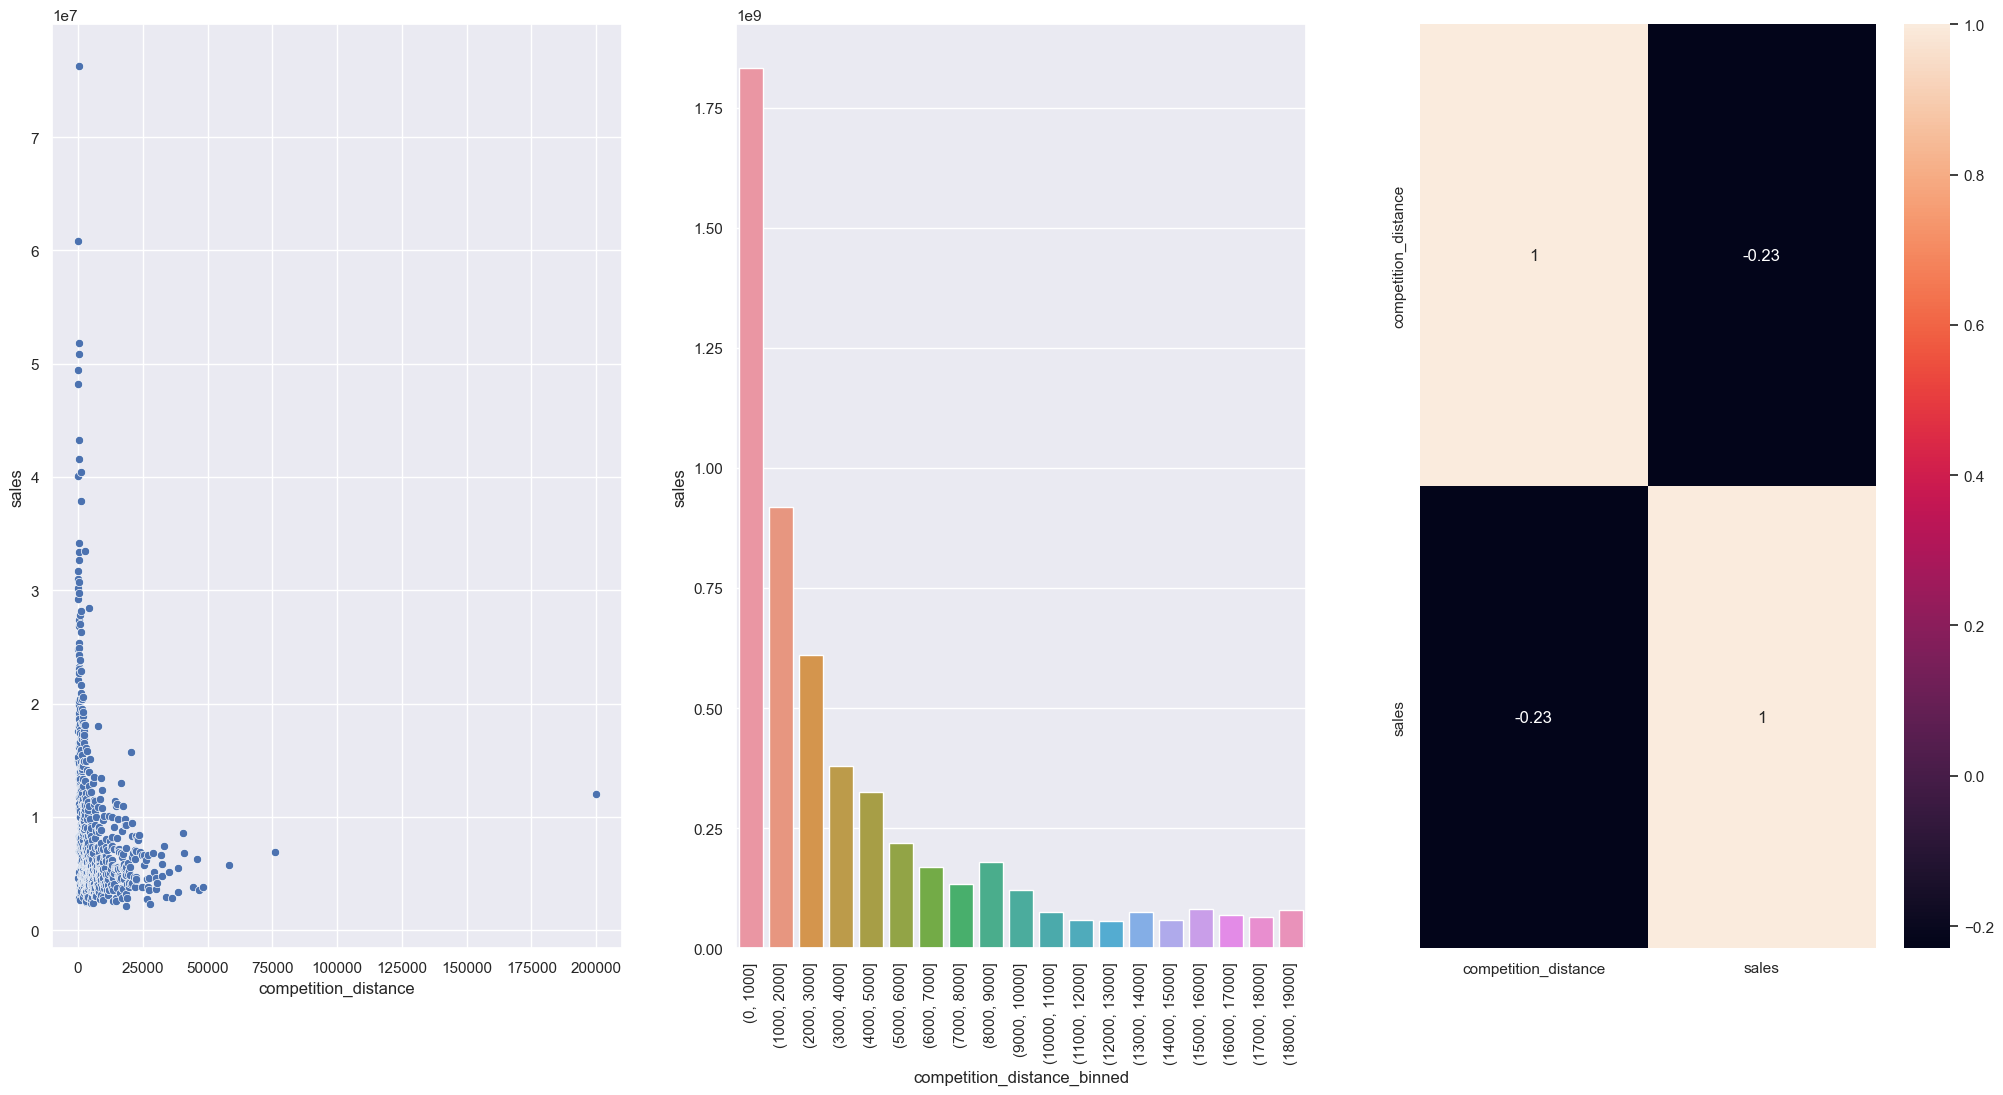

In [31]:
h2 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot( x='competition_distance', y='sales', data=h2 );

# Grouped
plt.subplot( 1, 3, 2)
bins = list( np.arange(0, 20000, 1000) )
h2['competition_distance_binned'] = pd.cut( h2['competition_distance'], bins=bins )
aux2 = h2[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# correlation 
plt.subplot( 1, 3, 3 )
sns.heatmap( h2.corr( method='pearson' ), annot=True );

##### **H6.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

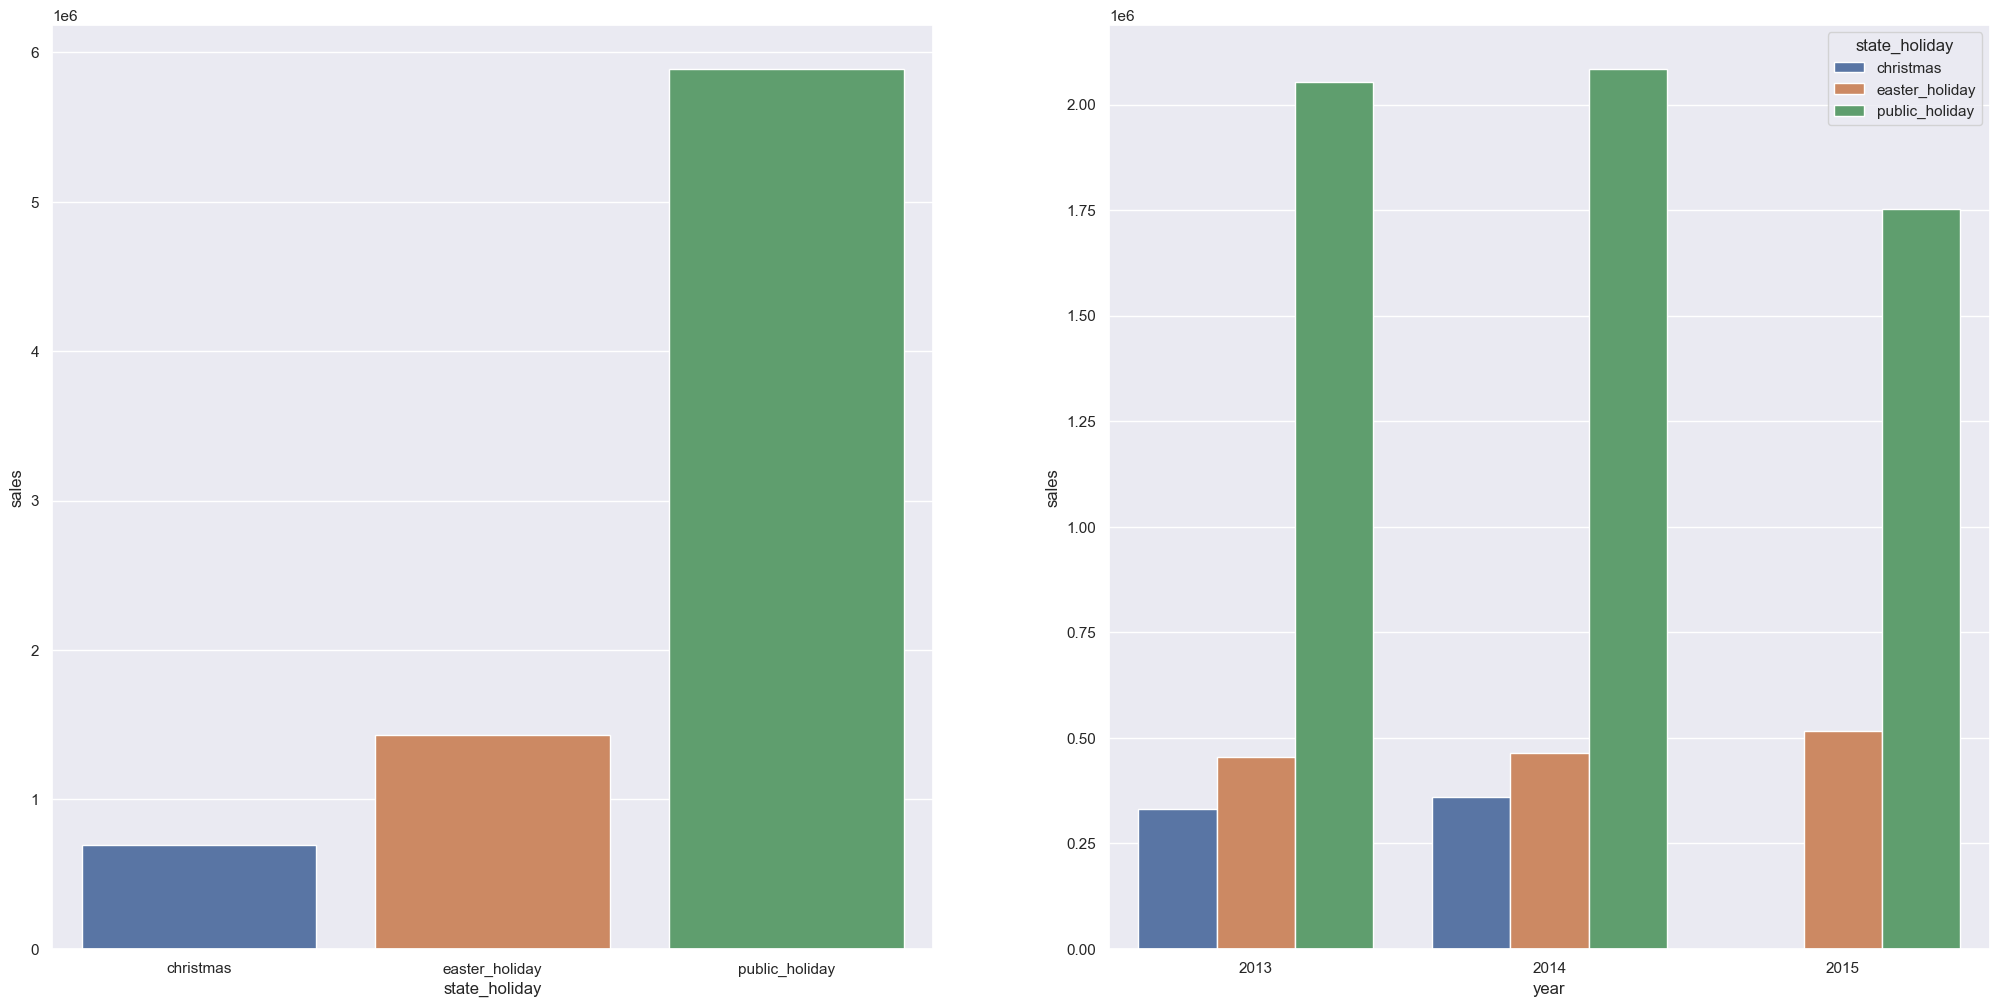

In [32]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

##### **H9.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

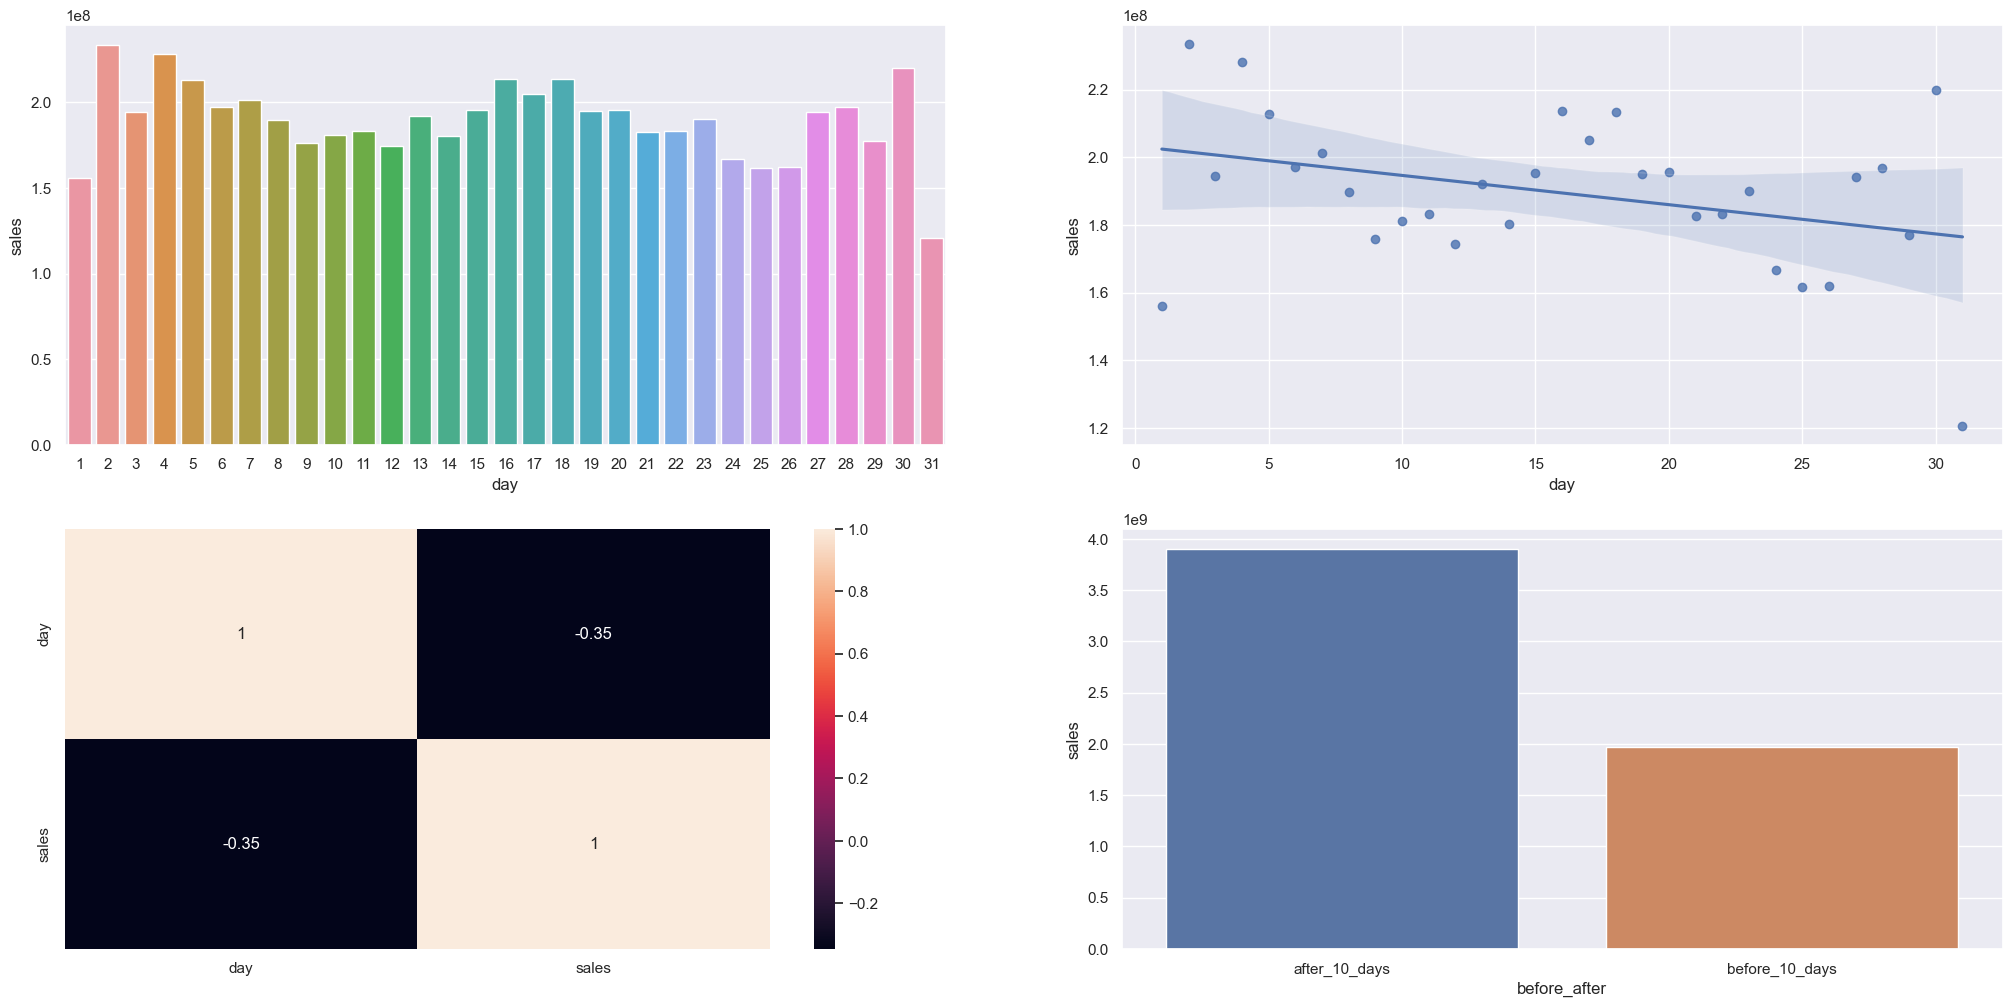

In [33]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

#### Less Relevant

##### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

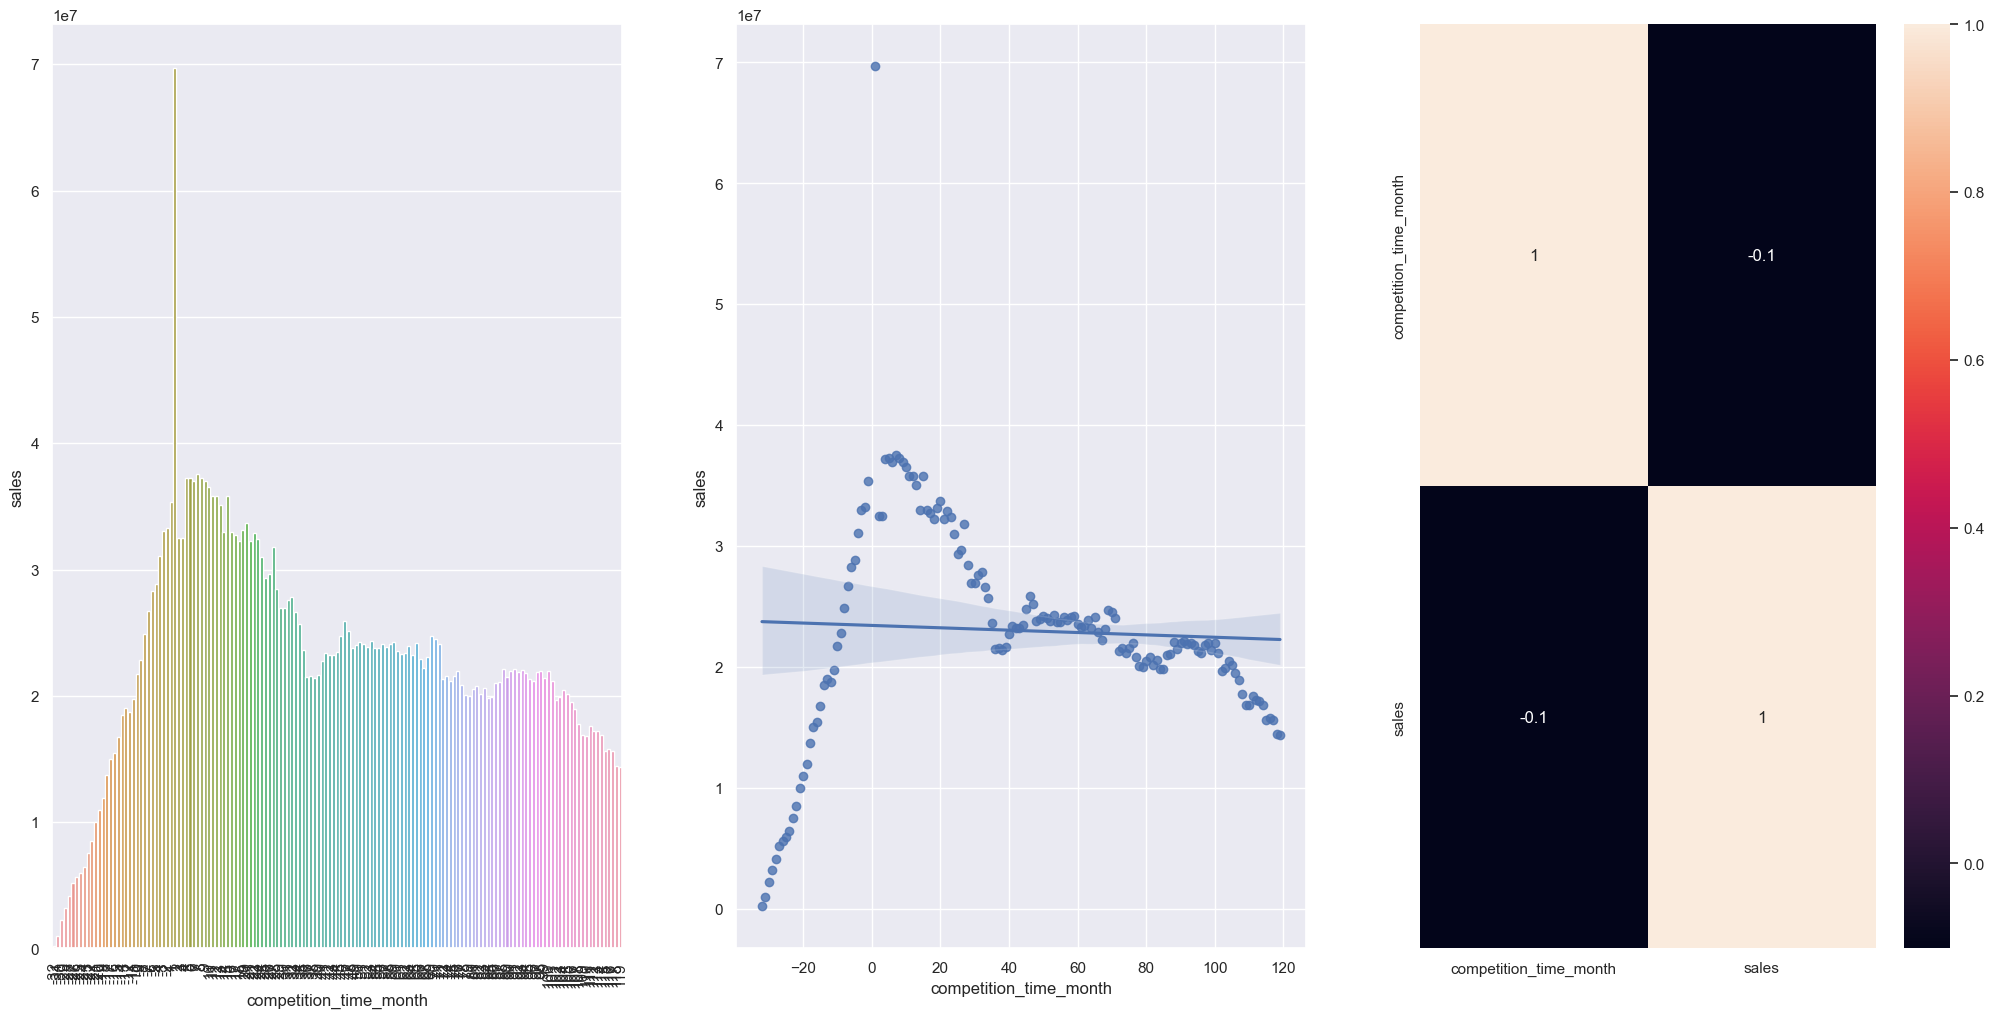

In [34]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
h3 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=h3 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=h3 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );


##### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

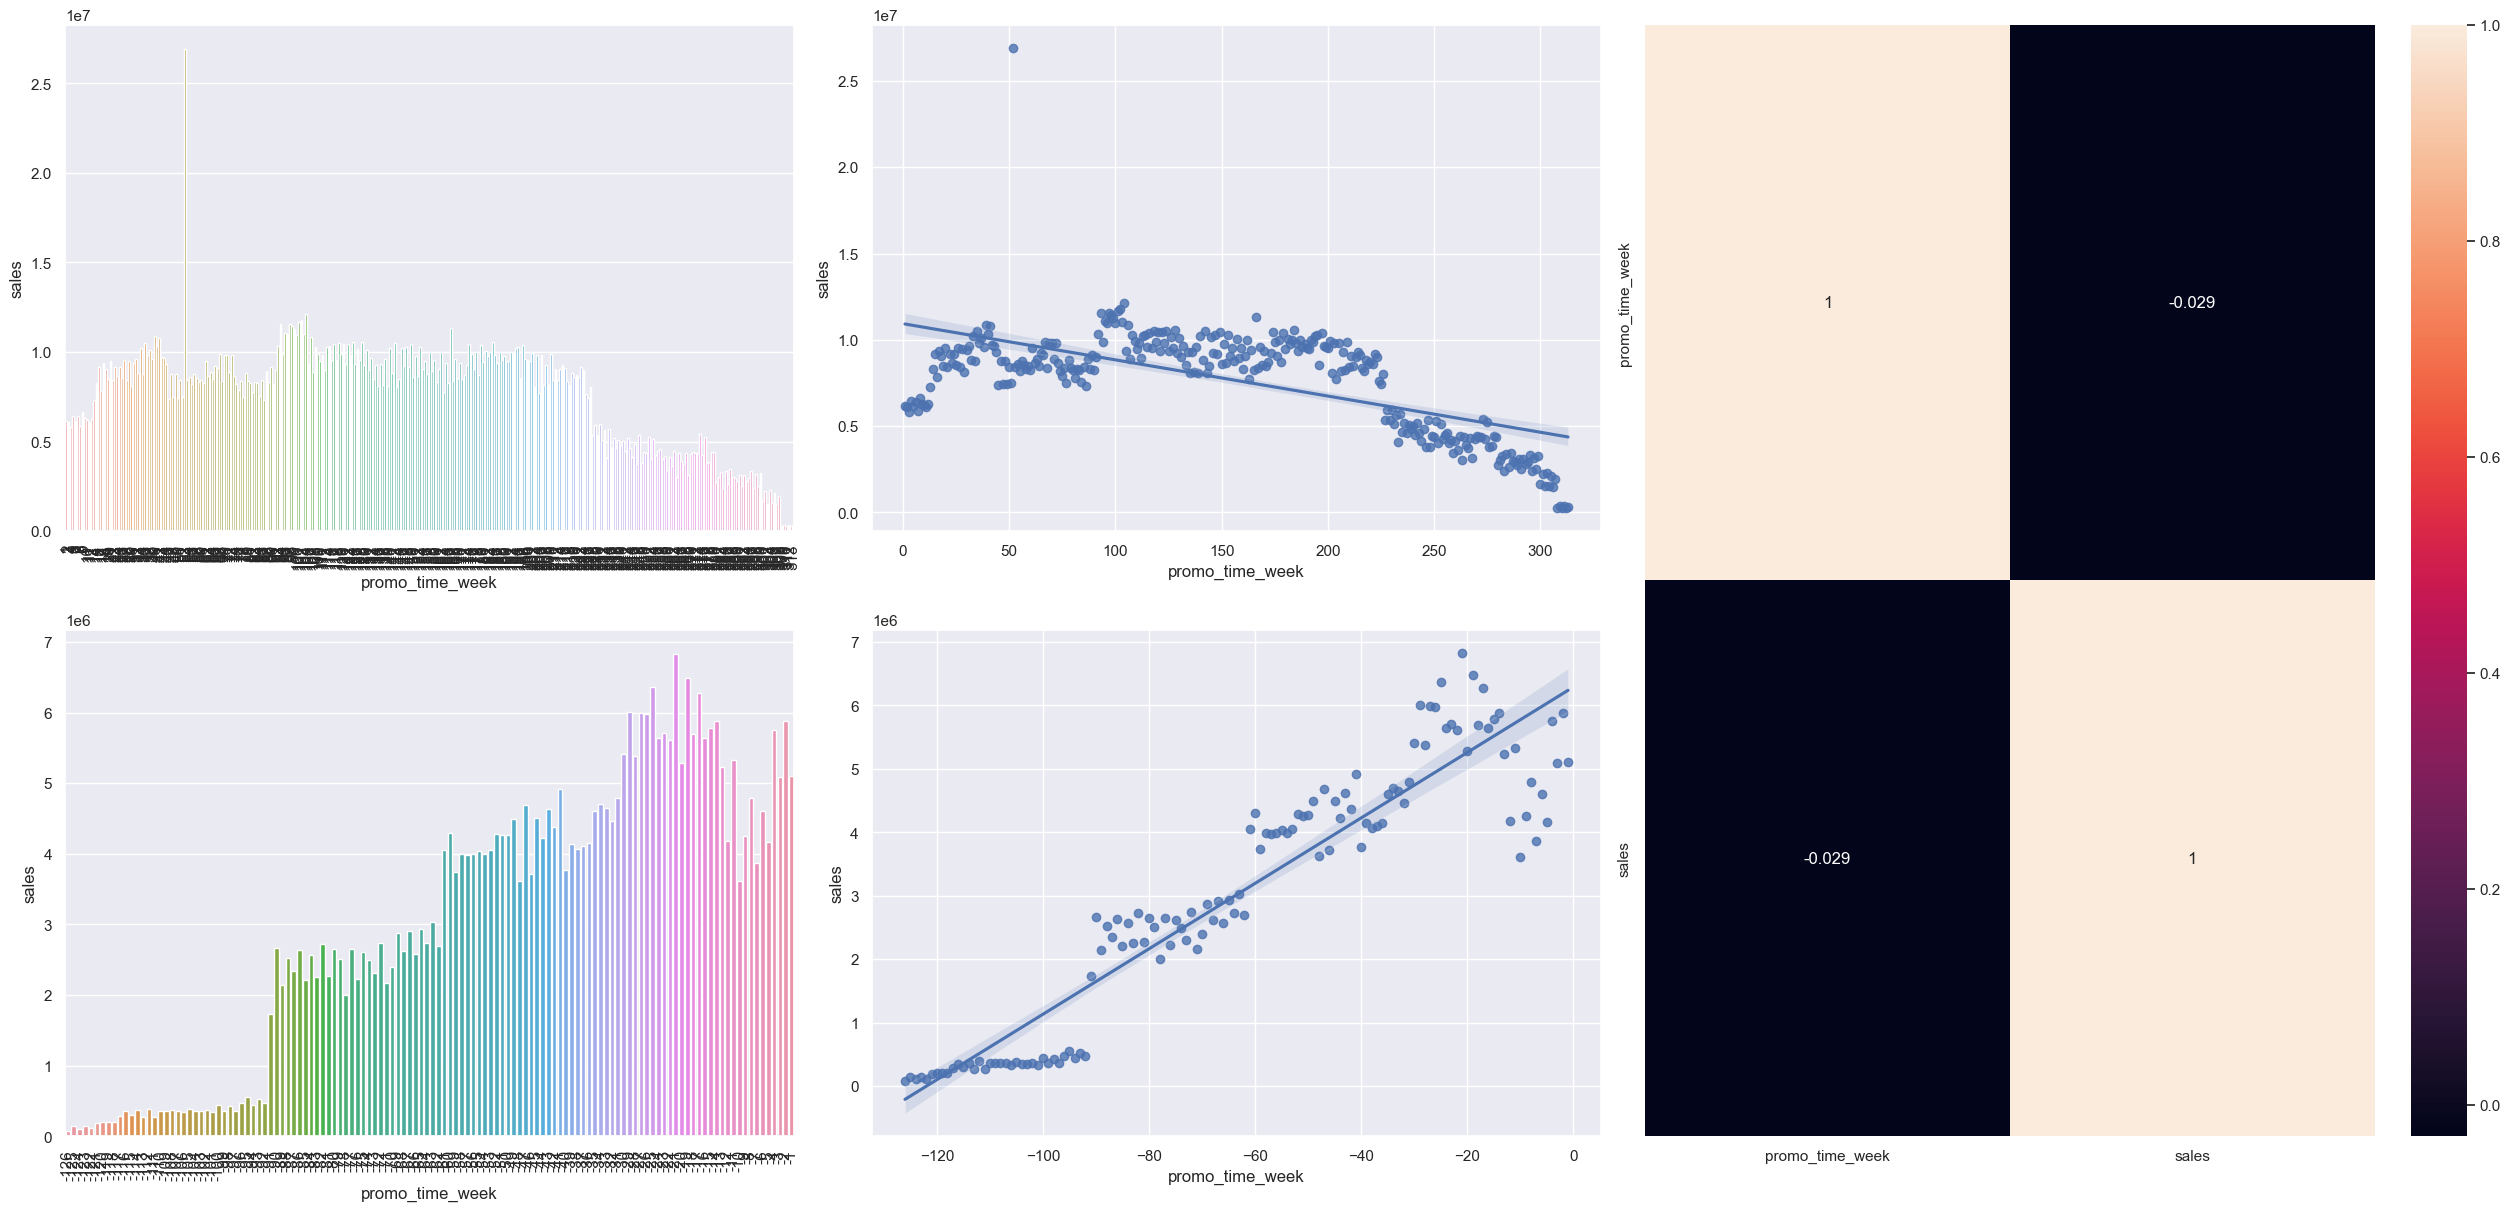

In [35]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

fig3 = plt.figure(constrained_layout=True)
grid = fig3.add_gridspec(2, 3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

##### **H5.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [36]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


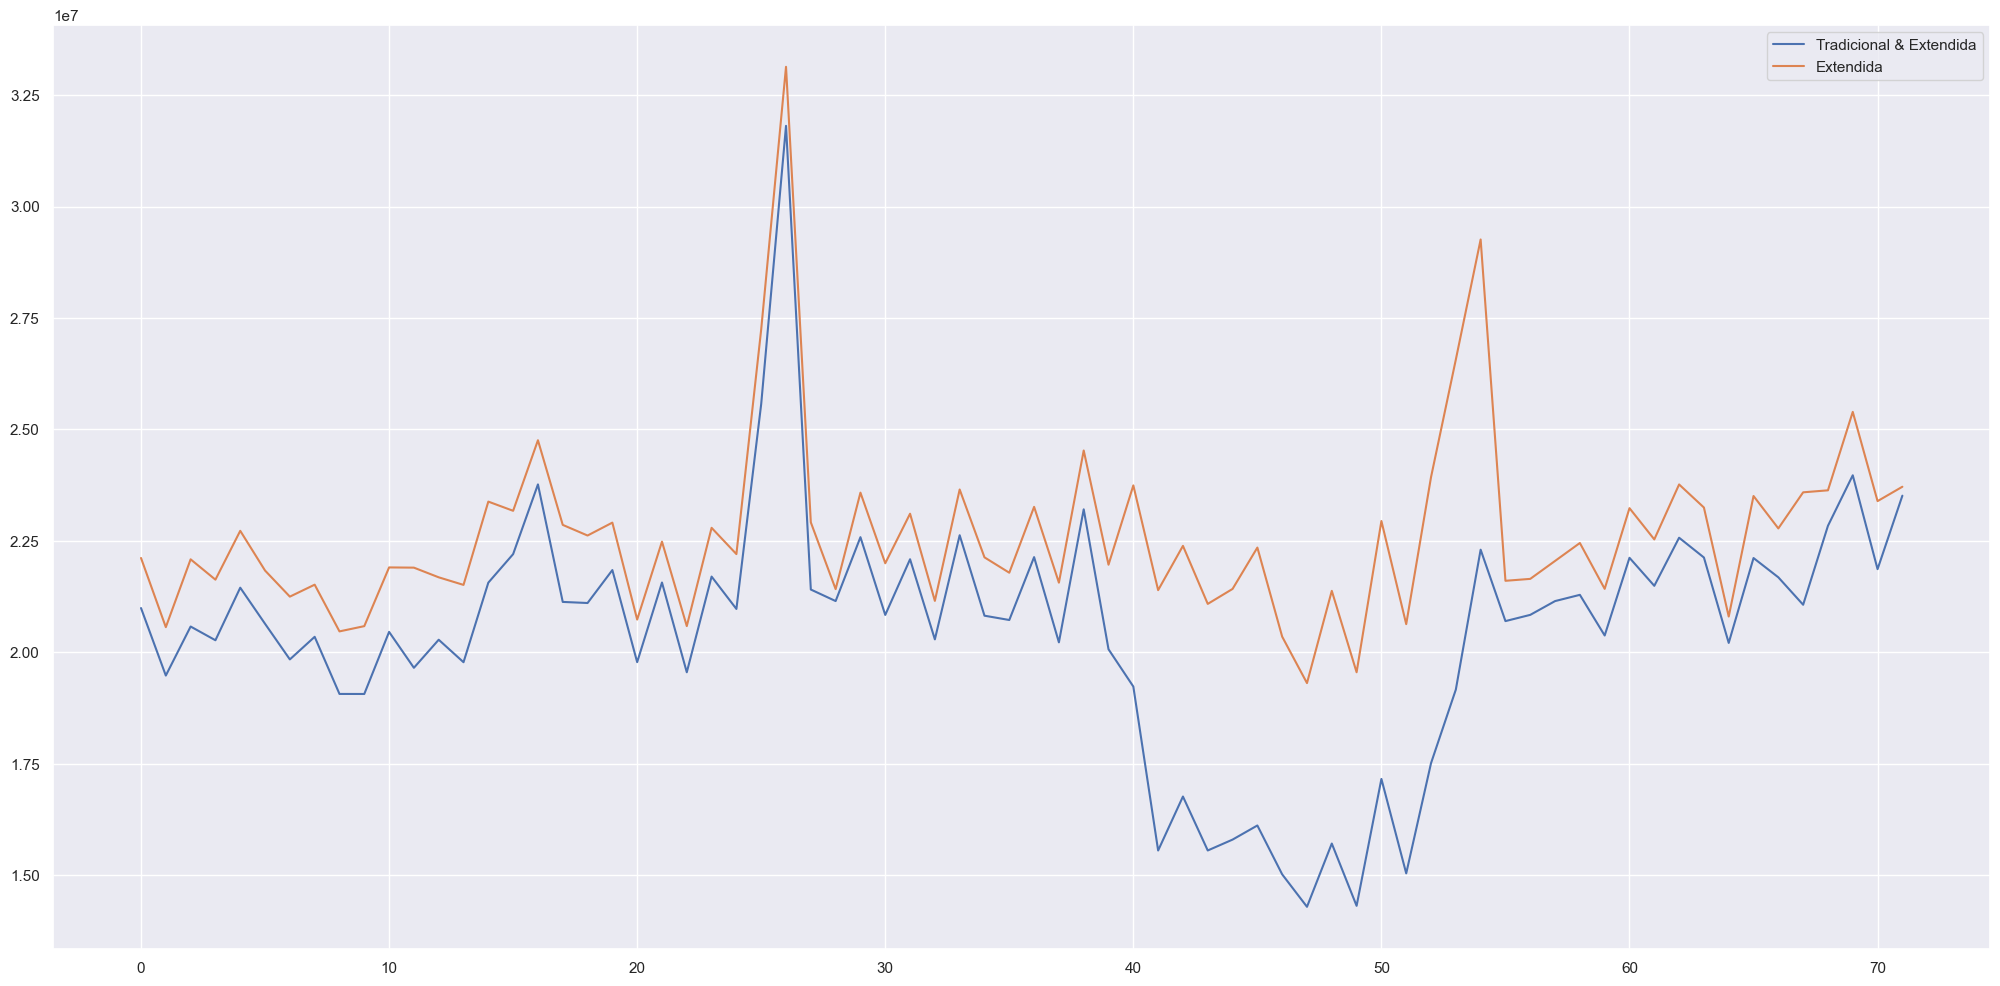

In [37]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

##### **H7.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

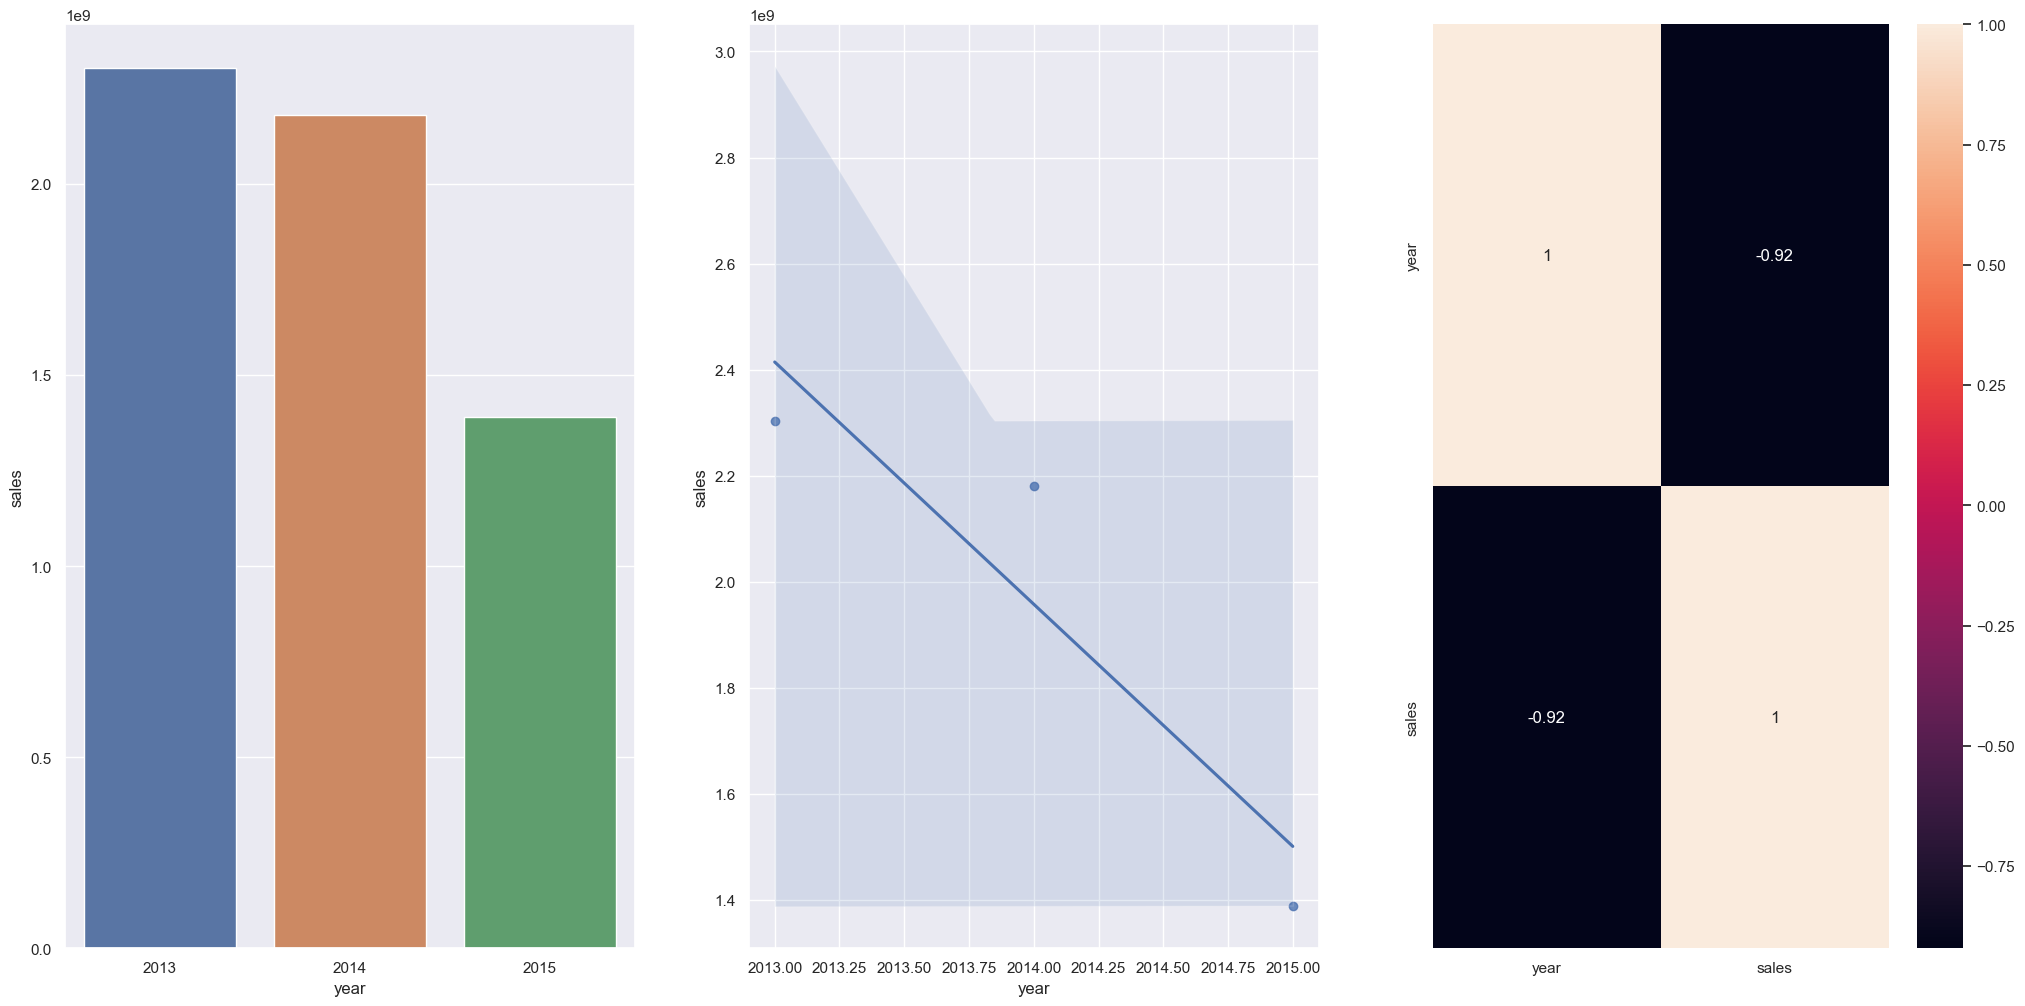

In [38]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

##### **H8.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

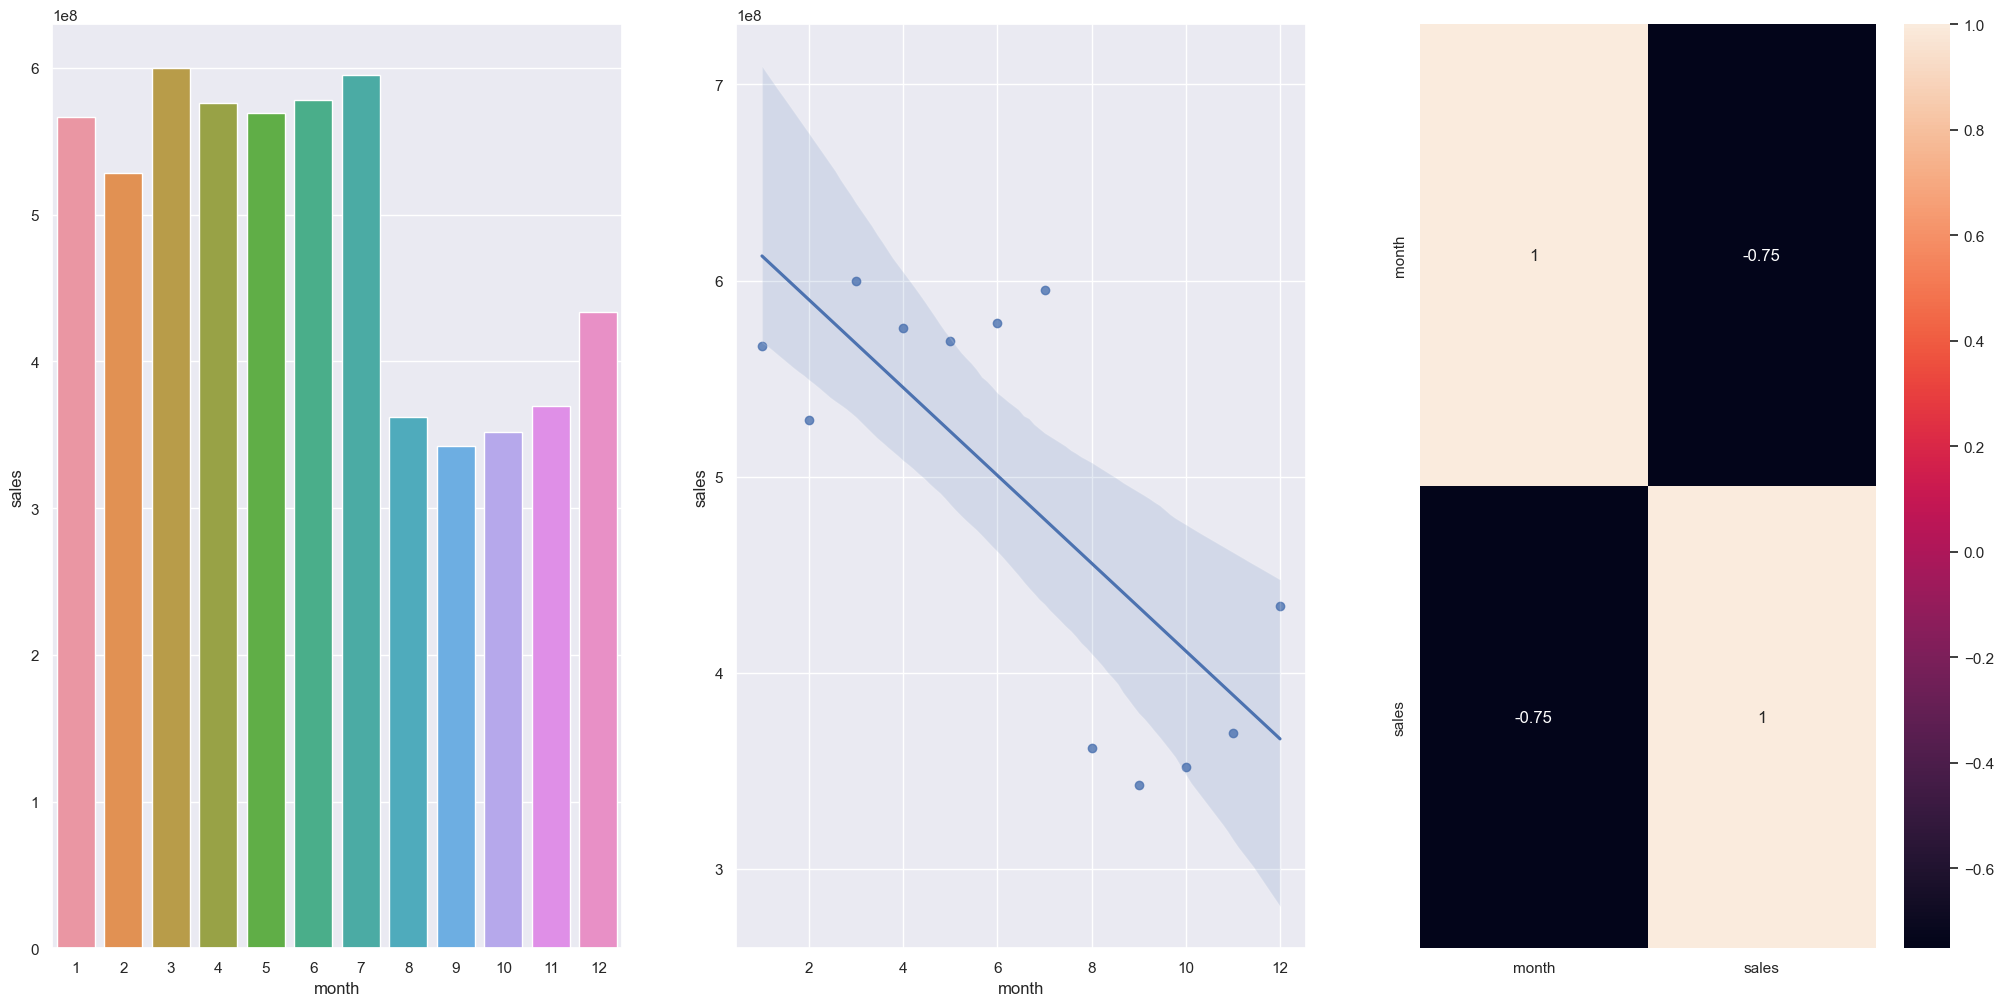

In [39]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

##### **H10.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

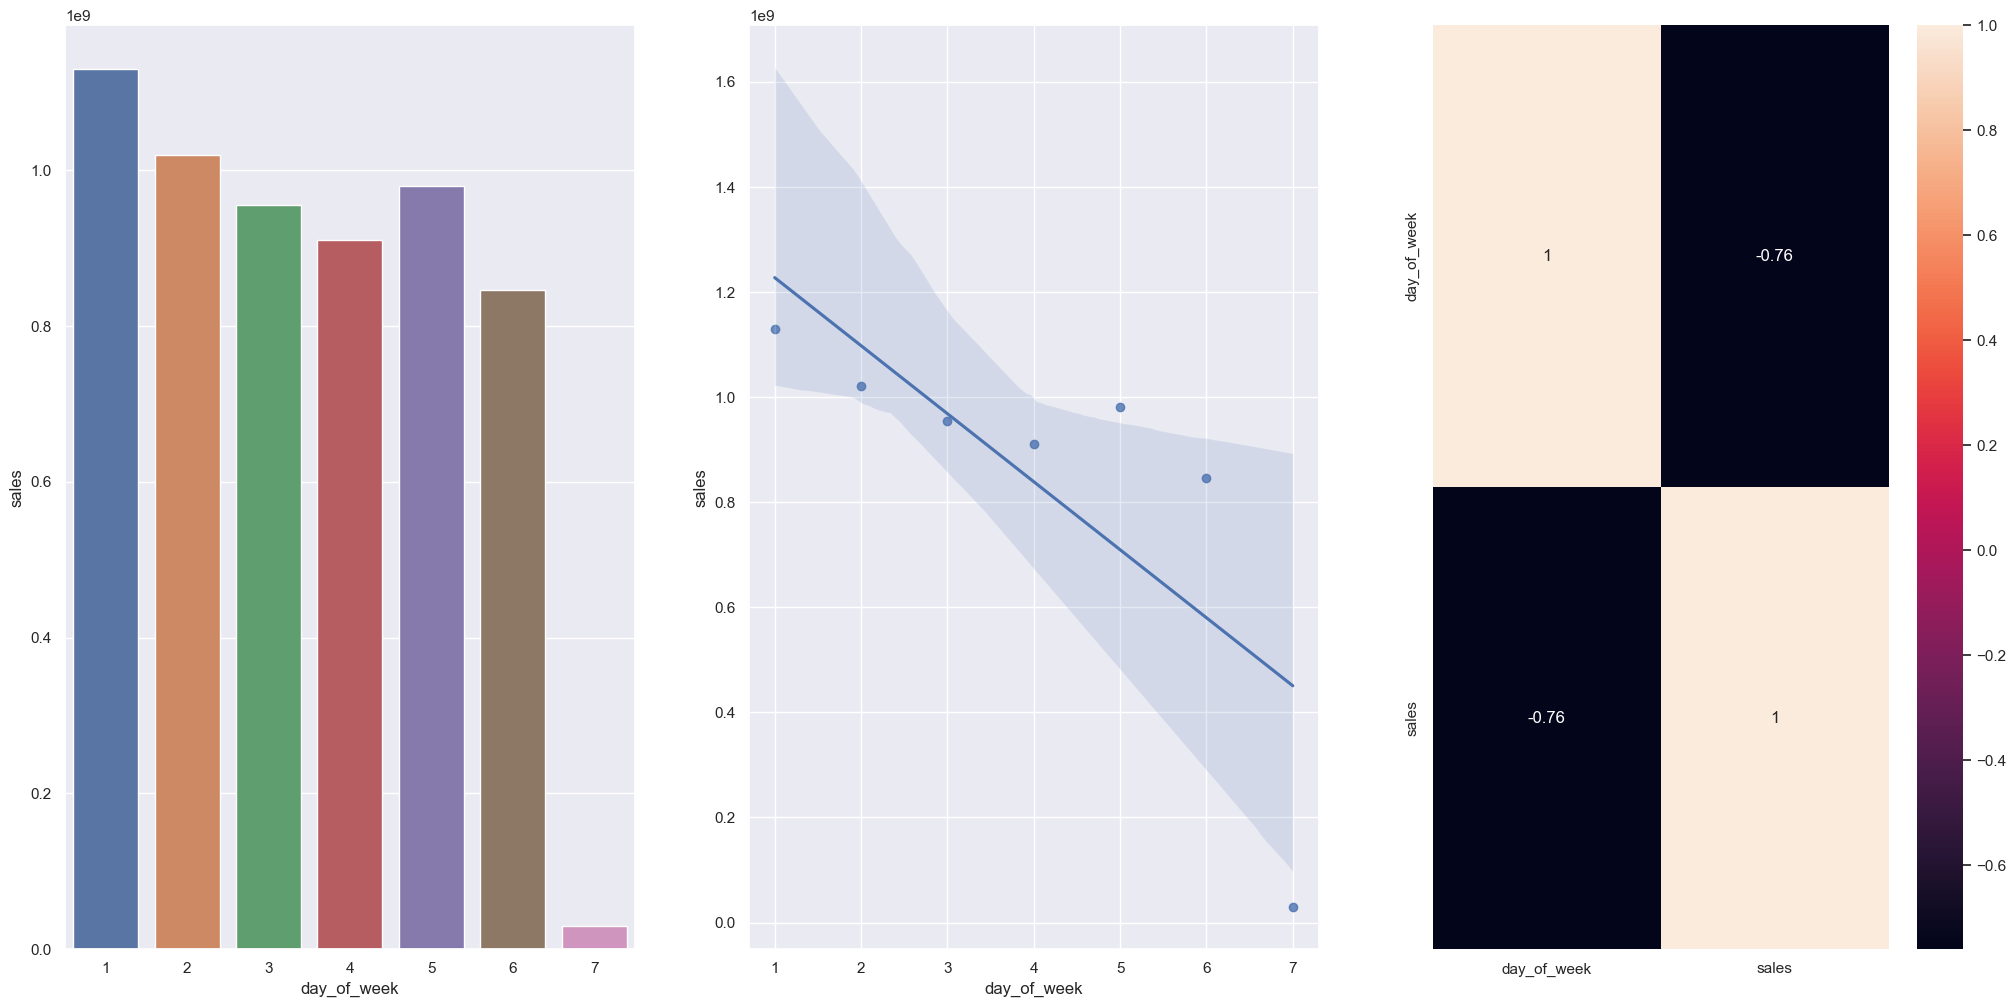

In [40]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

##### **H11.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

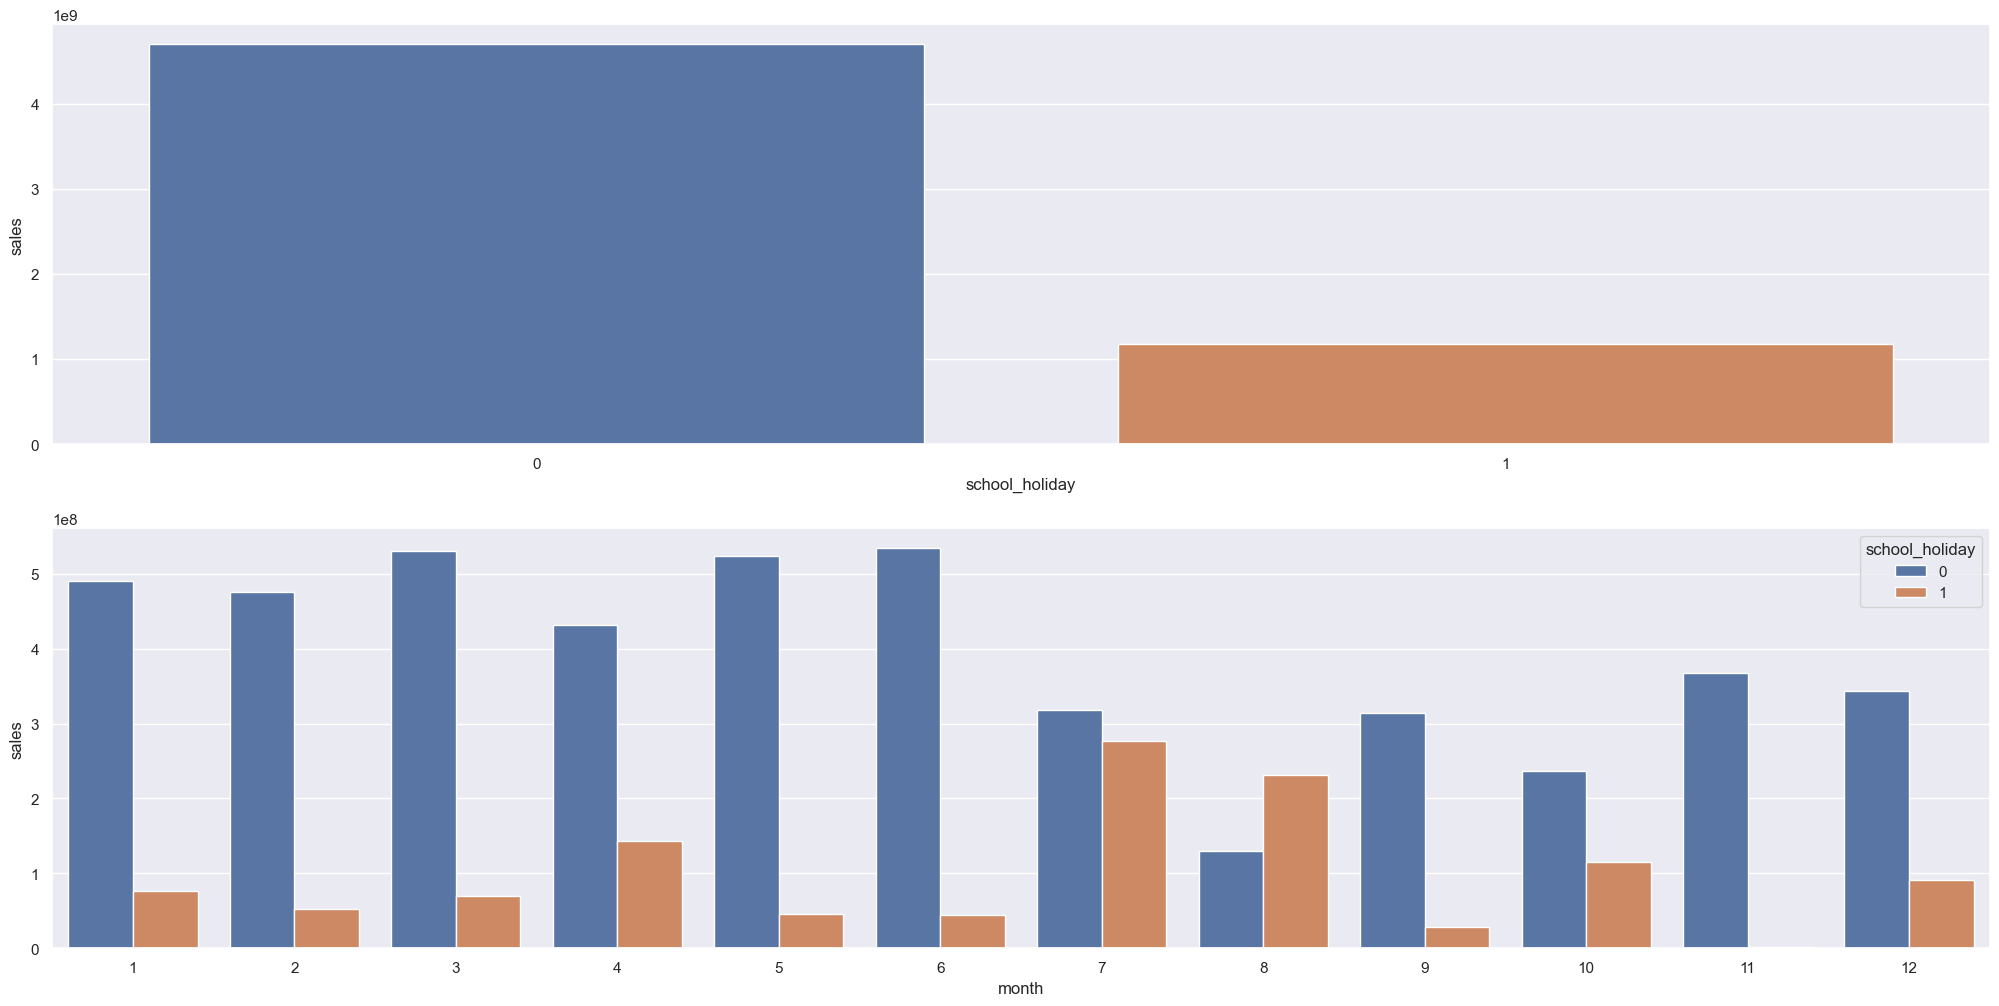

In [41]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### Multivariate analysis

#### Numerical Attributes

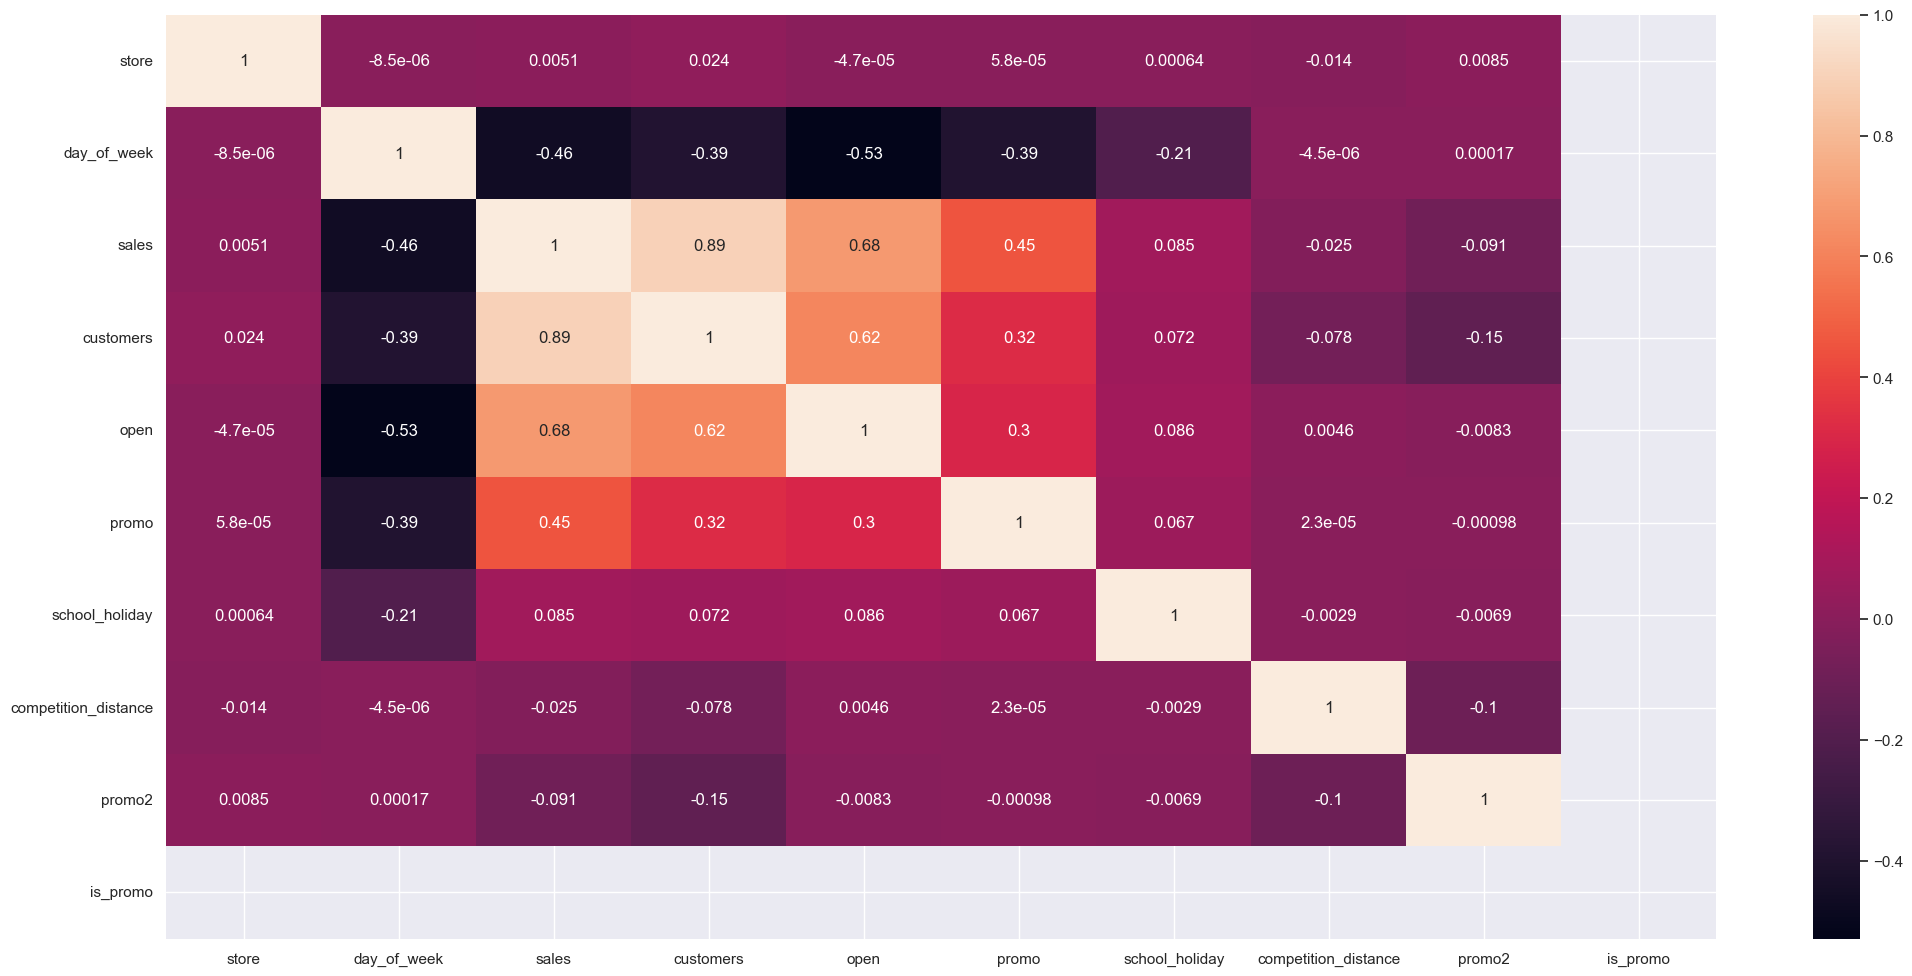

In [42]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

#### Categorical Attributes

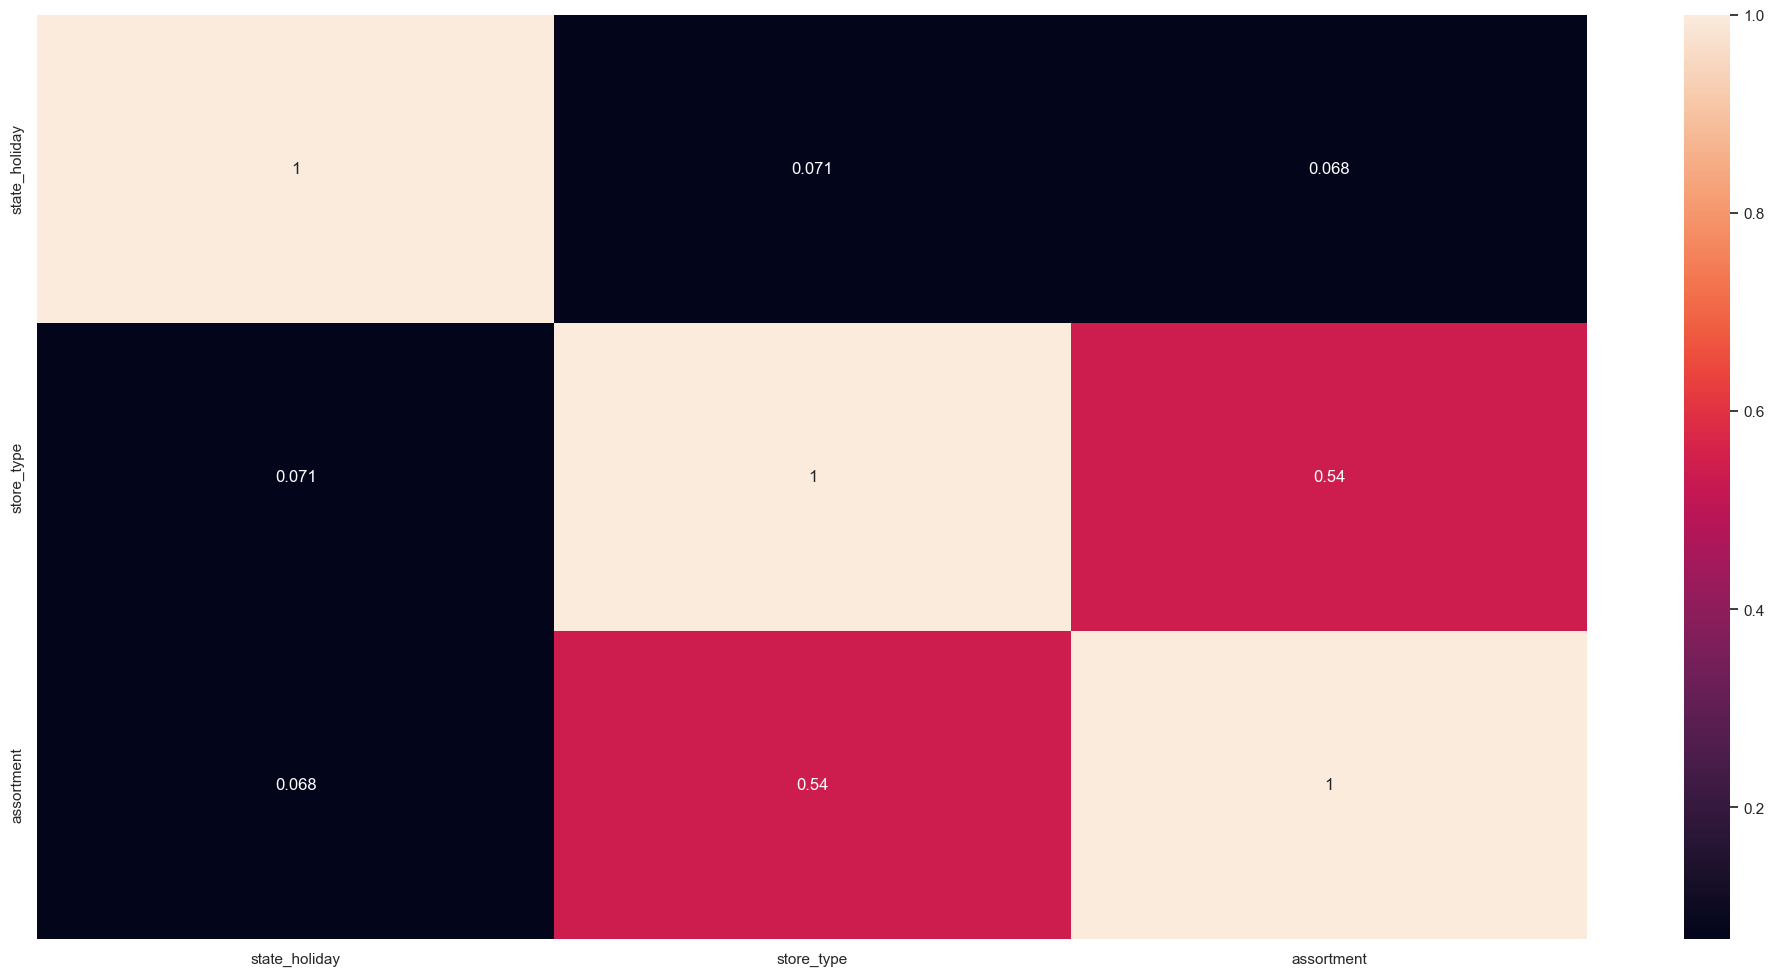

In [43]:
# only categorical data


a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# Data Preparation

In [44]:
#Saving
df5 = df4.copy()

### Rescalling

In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'api-test/parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'api-test/parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'api-test/parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'api-test/parameter/year_scaler.pkl', 'wb') )


### Transformation

Encoding

In [46]:
# state_holiday 
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type 
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'api-test/parameter/store_type_scaler.pkl', 'wb') )

# assortment 
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

Responsable Variabel TRansformation

In [47]:
df5['sales'] = np.log1p( df5['sales'] )

Nature Transformation

In [48]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# Feature Selection

In [49]:
df6 = df5.copy()

### Split Data

In [50]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 ) 

In [51]:
# #Searching dates

# # Inicial/final
# df6[['store', 'date']].groupby('store').min.reset_index() 
# df6[['store', 'date']].groupby('store').max.reset_index() 


# # Choosing weeks
# df6[['store', 'date']].groupby('store').max.reset_index()['date'][0] - datetime.timedelta( days=6*7 ) 

In [52]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### Boruta Feature Selector

In [53]:
# ## training and test dataset for Boruta

# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel() 

# ## define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# ## define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )


In [54]:
# cols_selected = boruta.support_.tolist()

# ## best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 ) 
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() 

# ## not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )


In [55]:
# cols_selected_boruta


# ['store',
#  'promo',
#  'store_type',
#  'assortment',
#  'competition_distance',
#  'competition_open_since_month',
#  'competition_open_since_year',
#  'promo2',
#  'promo2_since_week',
#  'promo2_since_year',
#  'competition_time_month',
#  'promo_time_week',
#  'day_of_week_sin',
#  'day_of_week_cos',
#  'month_cos',
#  'day_sin',
#  'day_cos',
#  'week_of_year_cos']

In [56]:
# cols_not_selected_boruta

# ['is_promo',
#  'month_sin',
#  'school_holiday',
#  'state_holiday_christmas',
#  'state_holiday_easter_holiday',
#  'state_holiday_public_holiday',
#  'state_holiday_regular_day',
#  'week_of_year_sin',
#  'year']

### Manual Feature Selection

In [57]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']


# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend( feat_to_add )

# Machine Learning

In [58]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## Choosing Models

### Average Model

In [59]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} ) 
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )

baseline_result
# RMSE: 1835

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### Linear Regression Model

In [60]:
# model 
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )

lr_result
# RMSE: 2671

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### Linear Regression Model - Cross Validation

In [61]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv # 2952

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


###  Linear Regression Regularized Model - Lasso

In [62]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )

lrr_result
# RMSE: 2744

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


####  Lasso - Cross Validation

In [63]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv #3057

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### Random Forest Regressor

In [64]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )

rf_result
# RMSE: 1011

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


####  Random Forest Regressor - Cross Validation

In [65]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv #1254


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


###  XGBoost Regressor

In [66]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10,
                              subsample=0.7, 
                              colsample_bytree=0.9 ).fit( x_train, y_train ) 

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result
# RMSE: 7330

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.544086,0.949457,7330.812159


####  XGBoost Regressor - Cross Validation

In [67]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv # 7715


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


## Compare Model's Performance

### Single Performance

In [68]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' ) 

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.544086,0.949457,7330.812159


### Real performance (Cross Validation)

In [69]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


# Hiperparameter fine tuning

### Random Search

In [70]:
# param = { 
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'min_child_weight': [3, 8, 15]
#        }

# MAX_EVAL = 5

In [71]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
   
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  min_child_weight=hp['min_child_weight'] )

#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )

# final_result
       

### Final Model

In [72]:
# {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'min_child_weight': 15}

param_tuned = {
    'n_estimators': 3500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'min_child_weight': 15
        }

In [73]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )


In [74]:
round(xgb_result_tuned, 2)

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,623.39,0.09,911.83


# Tradução e interpretação do erro

In [75]:
df9 = X_test[ cols_selected_boruta_full ].copy()

# rescale
df9.loc[:, 'sales'] = np.expm1( df9[ 'sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

### Busineess Performance

In [76]:
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'}) 
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' ) 
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

# df92.sort_values( 'MAPE', ascending=False ).head()
 
round(df92.sample(5), 2)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
387,388,367938.093750,367354.54,368521.58,583.52,0.06
142,143,231608.546875,231117.87,232099.19,490.66,0.08
939,940,267996.343750,267340.60,268652.09,655.75,0.09
883,884,223609.812500,223117.80,224101.82,492.01,0.08
971,972,125582.718750,125281.18,125884.26,301.54,0.10


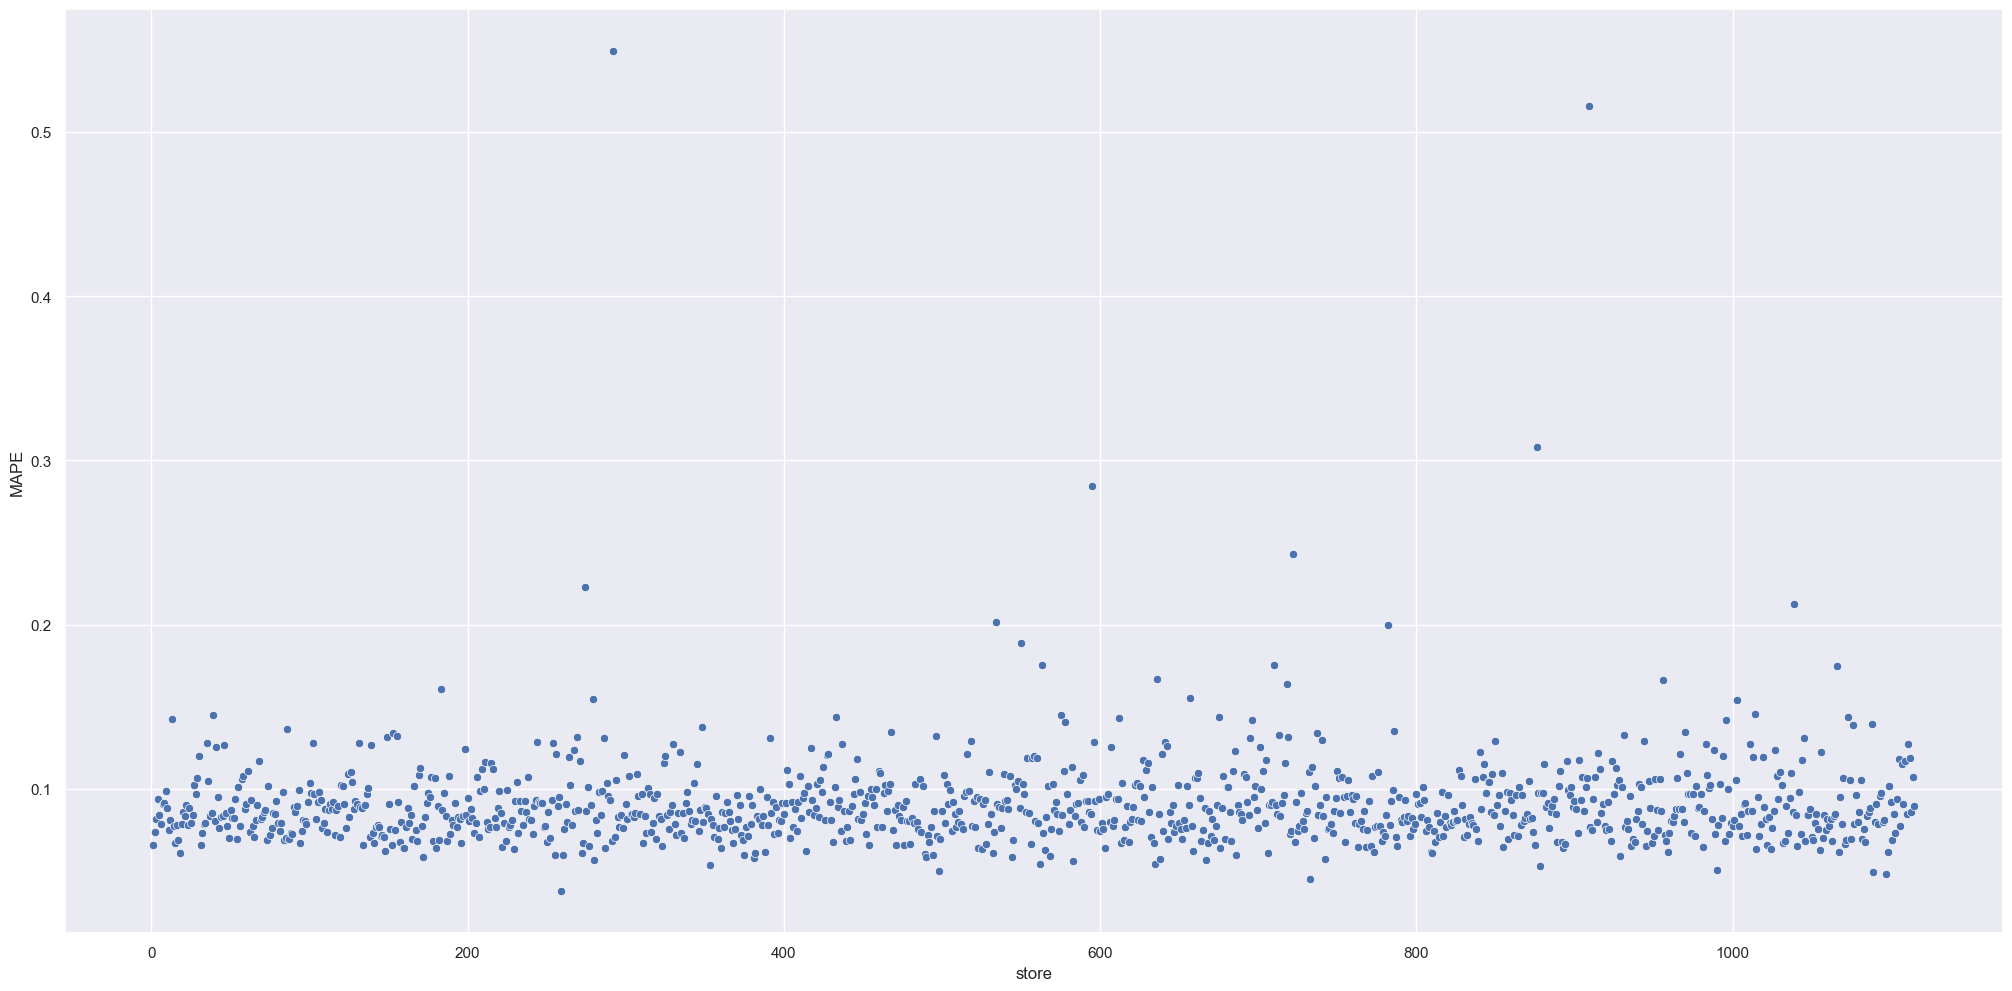

In [77]:
# Performance MAPE
sns.scatterplot( x='store', y='MAPE', data=df92 );

### Total Performance

In [78]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$283,057,088.00"
1,worst_scenario,"R$282,357,846.34"
2,best_scenario,"R$283,756,309.19"


### Machine Learning Performance

<Axes: xlabel='predictions', ylabel='error'>

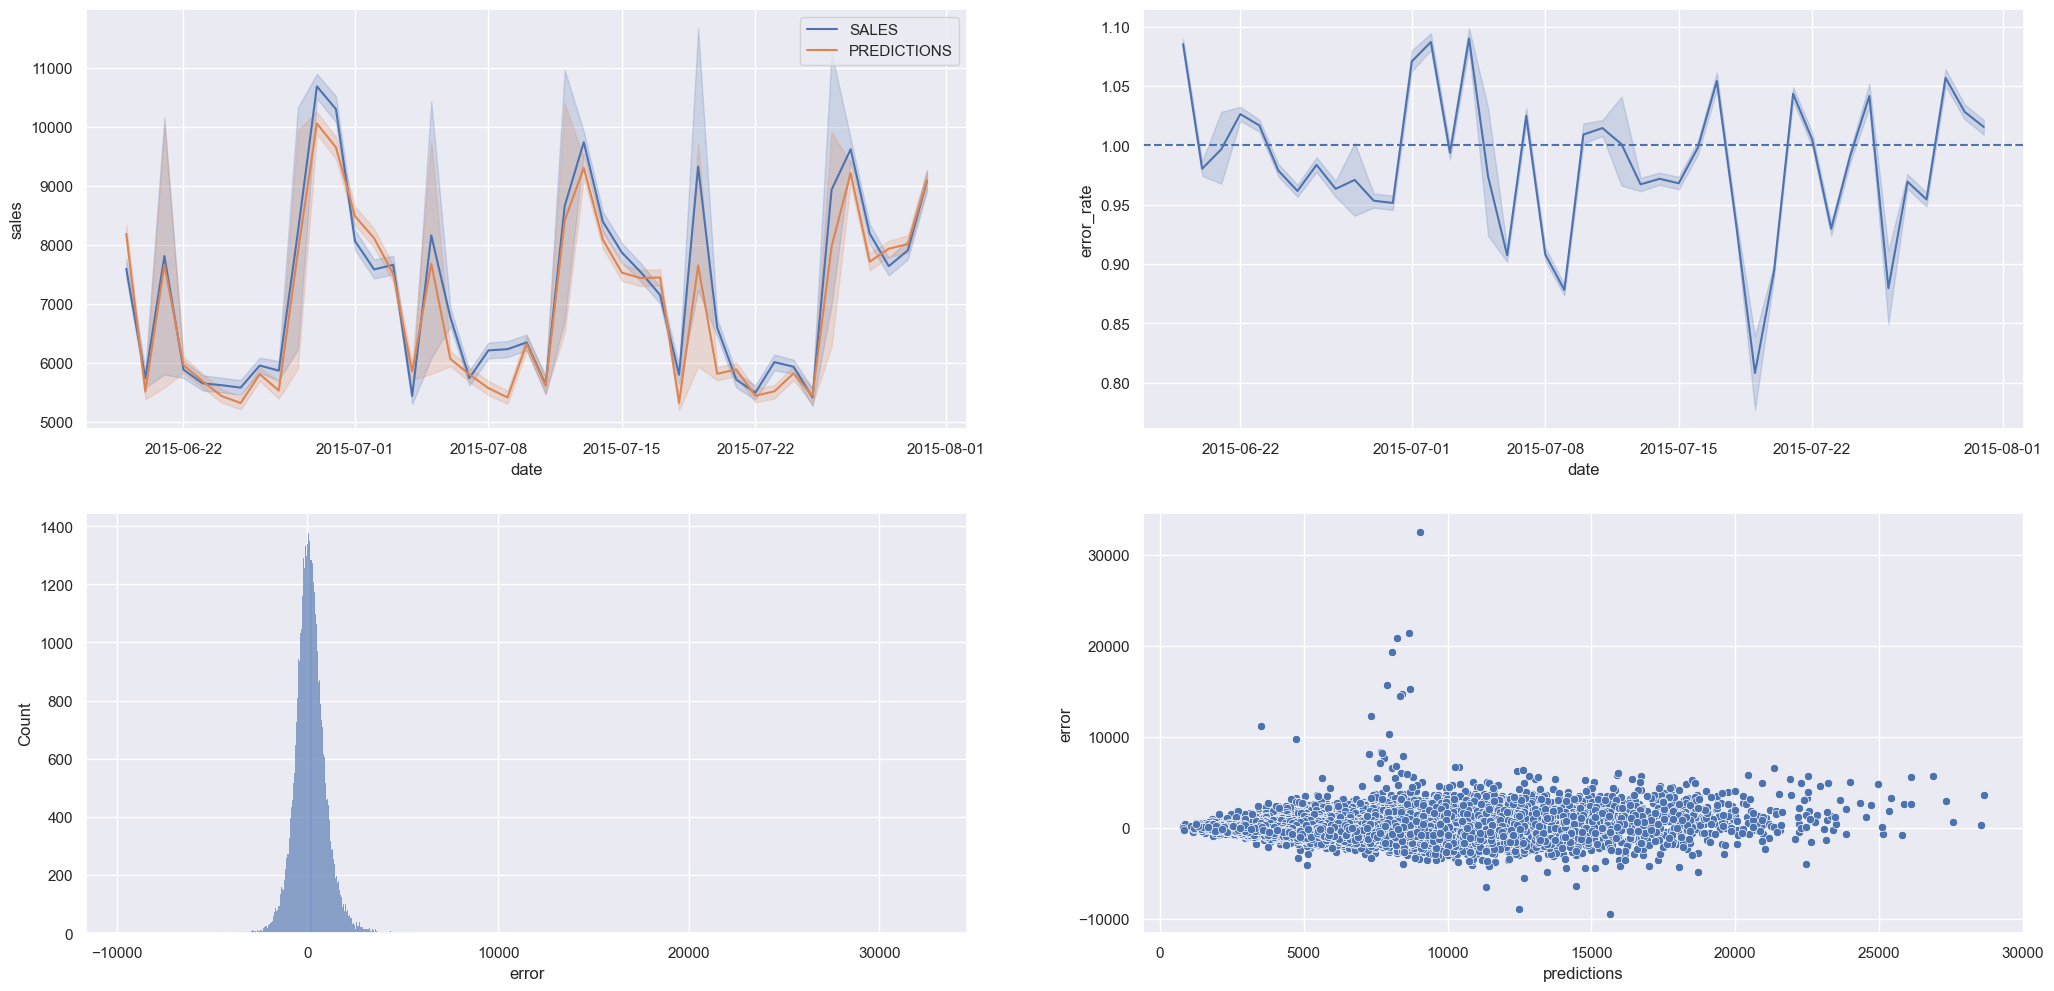

In [79]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

# Vendas reais + predições
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# Esperado
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

# Resíduo - Curva normal
plt.subplot( 2, 2, 3 )
sns.histplot( df9['error'] )

# Resíduo
plt.subplot( 2, 2, 4 )
sns.scatterplot( x='predictions', y='error', data=df9)


# Deploy

### Saving Trained Model

In [80]:
pickle.dump( model_xgb_tuned, open( 'C:/C.Python/1CDS/rossmann_project/api-test/model/model_xgb_Rossmann.pkl', 'wb' ) )

### Rossmann Class

In [81]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/C.Python/1CDS/rossmann_project/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'api-test/parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'api-test/parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'api-test/parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'api-test/parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'api-test/parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): # 1º
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
            
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]

    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )


### API Handler

In [82]:
# import pickle
# import pandas as pd
# from flask             import Flask, request, Response
# from rossmann.Rossmann import Rossmann


# # loading model - 4º
# model = pickle.load( open( 'C:/C.Python/1CDS/rossmann_project/api-test/model/model_xgb_Rossmann.pkl', 'rb') )

# # initialize API
# app = Flask( __name__ )

# @app.route( '/rossmann/predict', methods=['POST'] )


# def rossmann_predict():
#     test_json = request.get_json() 
   

#     if test_json: 
#         if isinstance( test_json, dict ): 
#             test_raw = pd.DataFrame( test_json, index=[0] )
            
#         else: 
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

#         pipeline = Rossmann()
        
#         # data cleaning
#         df1 = pipeline.data_cleaning( test_raw )
        
#         # feature engineering
#         df2 = pipeline.feature_engineering( df1 )
        
#         # data preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         # prediction
#         df_response = pipeline.get_prediction( model, test_raw, df3 )
        
#         return df_response
        
        
#     else:
#         return Response( '{}', status=200, mimetype='application/json' )
    
    

# if __name__ == '__main__':
#     app.run( '0.0.0.0' ) 
#     # http://192.168.15.150:5000/


### API Tester

In [83]:
# loading test dataset
df10 = pd.read_csv( 'C:/C.Python/1CDS/rossmann_project/dataset/test_rossmann.csv' )


In [84]:
# merge test dataset + store 
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] 
df_test = df_test.drop( 'Id', axis=1 )

data = json.dumps( df_test.to_dict( orient='records' ) ) 

In [85]:
# API Call
# url = 'http://192.168.15.150:5000/rossmann/predict'
url = 'https://rossmann-project.onrender.com/rossmann/predict'


header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [86]:
# Convert DataFrame
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )


Store Number 20 will sell R$283,957.92 in the next 6 weeks
Store Number 22 will sell R$241,285.18 in the next 6 weeks
Store Number 23 will sell R$218,313.39 in the next 6 weeks
